# Telecom Churn Case Study - Kaggle

---


---



#### Created by: Sree Satya Latha and Supriya Uppala

## Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
from imblearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Reading the dataset

train = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(train.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [3]:
# Inspecting the data dictionary
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

In [4]:
# Inspecting the train dataset
train.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [5]:
# Statistics summary of the train dataset
train.describe()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count  69999.000000    69999.0         69297.0         69297.0   
mean   34999.000000      109.0             0.0             0.0   
std    20207.115084        0.0             0.0             0.0   
min        0.000000      109.0             0.0             0.0   
25%    17499.500000      109.0             0.0             0.0   
50%    34999.000000      109.0             0.0             0.0   
75%    52498.500000      109.0             0.0             0.0   
max    69998.000000      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count         69297.0  69999.000000  69999.000000  69999.000000  67231.000000   
mean              0.0    283.134365    278.185912    278.858826    133.153275   
std               0.0    334.213918    344.366927    351.924315    299.963093   
min               0.0  -2258.709000  -1289.715000   -945.808000      0.000000   
25%               0.0     93.581000     86.714000     84.095000      7.410000   
50%               0.0    197.484000    191.588000    192.234000     34.110000   
75%               0.0    370.791000    365.369500    369.909000    119.390000   
max               0.0  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7  ...   sachet_3g_7   sachet_3g_8     fb_user_6  \
count  67312.000000  ...  69999.000000  69999.000000  17568.000000   
mean     133.894438  ...      0.081444      0.085487      0.916325   
std      311.277193  ...      0.634547      0.680035      0.276907   
min        0.000000  ...      0.000000      0.000000      0.000000   
25%        6.675000  ...      0.000000      0.000000      1.000000   
50%       32.280000  ...      0.000000      0.000000      1.000000   
75%      115.837500  ...      0.000000      0.000000      1.000000   
max     8157.780000  ...     33.000000     41.000000      1.000000   

          fb_user_7     fb_user_8           aon    aug_vbc_3g    jul_vbc_3g  \
count  17865.000000  18417.000000  69999.000000  69999.000000  69999.000000   
mean       0.909544      0.890319   1220.639709     68.108597     65.935830   
std        0.286842      0.312501    952.426321    269.328659    267.899034   
min        0.000000      0.000000    180.000000      0.000000      0.000000   
25%        1.000000      1.000000    468.000000      0.000000      0.000000   
50%        1.000000      1.000000    868.000000      0.000000      0.000000   
75%        1.000000      1.000000   1813.000000      0.000000      0.000000   
max        1.000000      1.000000   4337.000000  12916.220000   9165.600000   

        jun_vbc_3g  churn_probability  
count  69999.00000       69999.000000  
mean      60.07674           0.101887  
std      257.22681           0.302502  
min        0.00000           0.000000  
25%        0.00000           0.000000  
50%        0.00000           0.000000  
75%        0.00000           0.000000  
max    11166.21000           1.000000  

[8 rows x 163 columns]

In [6]:
# Creating the copy of the original training set
telecom_df = train.copy()

In [7]:
# Creating the copy of the original test set
telecom_test_df = unseen.copy()

## 2. Data Cleaning and Preparation

### 2.1. Checking the columns with single unique value

In [8]:
cols_with_single_value = []
for col in train.columns:
    if train[col].nunique() == 1:
        cols_with_single_value.append(col)

print(cols_with_single_value)

['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


In [9]:
# Inspecting above columns
for col in cols_with_single_value:
    print(col)
    print(train[col].value_counts(dropna=False))
    print("--------------------------------------")

circle_id
circle_id
109    69999
Name: count, dtype: int64
--------------------------------------
loc_og_t2o_mou
loc_og_t2o_mou
0.0    69297
NaN      702
Name: count, dtype: int64
--------------------------------------
std_og_t2o_mou
std_og_t2o_mou
0.0    69297
NaN      702
Name: count, dtype: int64
--------------------------------------
loc_ic_t2o_mou
loc_ic_t2o_mou
0.0    69297
NaN      702
Name: count, dtype: int64
--------------------------------------
last_date_of_month_6
last_date_of_month_6
6/30/2014    69999
Name: count, dtype: int64
--------------------------------------
last_date_of_month_7
last_date_of_month_7
7/31/2014    69600
NaN            399
Name: count, dtype: int64
--------------------------------------
last_date_of_month_8
last_date_of_month_8
8/31/2014    69266
NaN            733
Name: count, dtype: int64
--------------------------------------
std_og_t2c_mou_6
std_og_t2c_mou_6
0.0    67231
NaN     2768
Name: count, dtype: int64
-------------------------------------

In [10]:
# Based on the dataset, we remove these columns from the training set
train.drop(cols_with_single_value, axis=1, inplace=True)

# Based on the dataset, we remove these columns from the test set
unseen.drop(cols_with_single_value, axis=1, inplace=True)

In [11]:
# Remove the id column since it is unique for every row from the training set
train.drop('id', axis=1, inplace=True)

In [12]:
# Generating a list of column names based on their corresponding types

date_cols = ['date_of_last_rech_6',
            'date_of_last_rech_7',
            'date_of_last_rech_8',
            'date_of_last_rech_data_6',
            'date_of_last_rech_data_7',
            'date_of_last_rech_data_8',
            ]

cat_cols = ['night_pck_user_6',
            'night_pck_user_7',
            'night_pck_user_8',
            'fb_user_6',
            'fb_user_7',
            'fb_user_8',
           ]

numerical_cols = [col for col in train.columns if col not in date_cols + cat_cols]

In [13]:
# Dropping date columns as they are not useful for our analysis from the training set
train.drop(columns=date_cols, axis=1, inplace=True)

# Dropping date columns as they are not useful for our analysis from the test set
unseen.drop(columns=date_cols, axis=1, inplace=True)

In [14]:
### Check for columns with more than 70% missing values in the training dataset
mv_train_set = round(100*(train.isna().sum(axis=0)/train.shape[0]), 2)
mv_train_set[mv_train_set > 70].sort_values(ascending=False)

total_rech_data_6     74.90
arpu_3g_6             74.90
max_rech_data_6       74.90
fb_user_6             74.90
count_rech_2g_6       74.90
night_pck_user_6      74.90
count_rech_3g_6       74.90
arpu_2g_6             74.90
av_rech_amt_data_6    74.90
fb_user_7             74.48
night_pck_user_7      74.48
arpu_2g_7             74.48
arpu_3g_7             74.48
av_rech_amt_data_7    74.48
total_rech_data_7     74.48
count_rech_3g_7       74.48
count_rech_2g_7       74.48
max_rech_data_7       74.48
av_rech_amt_data_8    73.69
count_rech_3g_8       73.69
arpu_3g_8             73.69
count_rech_2g_8       73.69
arpu_2g_8             73.69
max_rech_data_8       73.69
night_pck_user_8      73.69
total_rech_data_8     73.69
fb_user_8             73.69
dtype: float64

There are numerous variables with consistent percentages of missing data, suggesting a pattern of meaningful absence. Our strategy involves grouping similar data for analysis:

1. Grouping and treating missing values for 'recharge-related' data.
2. Grouping and treating missing values for 'ARPU' data.
3. Conducting missing value treatment on categorical columns.

#### Recharge Columns

In [15]:
# Columns with recharge information
recharge_cols = train.columns[train.columns.str.contains('_rech_')]
print(recharge_cols)

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'],
      dtype='object')


In [16]:
# Replacing NaN values in recharge related columns with 0 in the training set
train[recharge_cols] = train[recharge_cols].fillna(0)
print(train[recharge_cols].isnull().sum()*100/train.shape[1])

total_rech_num_6      0.0
total_rech_num_7      0.0
total_rech_num_8      0.0
total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8      0.0
max_rech_amt_6        0.0
max_rech_amt_7        0.0
max_rech_amt_8        0.0
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
count_rech_2g_6       0.0
count_rech_2g_7       0.0
count_rech_2g_8       0.0
count_rech_3g_6       0.0
count_rech_3g_7       0.0
count_rech_3g_8       0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
dtype: float64


In [17]:
# Replacing NaN values in recharge related columns with 0 in the test set
unseen[recharge_cols] = unseen[recharge_cols].fillna(0)
print(unseen[recharge_cols].isnull().sum()*100/unseen.shape[1])

total_rech_num_6      0.0
total_rech_num_7      0.0
total_rech_num_8      0.0
total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8      0.0
max_rech_amt_6        0.0
max_rech_amt_7        0.0
max_rech_amt_8        0.0
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
count_rech_2g_6       0.0
count_rech_2g_7       0.0
count_rech_2g_8       0.0
count_rech_3g_6       0.0
count_rech_3g_7       0.0
count_rech_3g_8       0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
dtype: float64


#### ARPU Columns

In [18]:
# Columns with 'arpu' information
arpu_cols = train.columns[train.columns.str.contains('arpu_')]
print(arpu_cols)

Index(['arpu_6', 'arpu_7', 'arpu_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8'],
      dtype='object')


In [19]:
# Replacing NaN values in ARPU related columns with 0 in the training set
train[arpu_cols] = train[arpu_cols].fillna(0)
print(train[arpu_cols].isnull().sum()*100/train.shape[1])

arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64


In [20]:
# Replacing NaN values in ARPU related columns with 0 in the test set
unseen[arpu_cols] = unseen[arpu_cols].fillna(0)
print(unseen[arpu_cols].isnull().sum()*100/unseen.shape[1])

arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64


#### Categorical Columns

In [21]:
# Inspecting categorical columns
train[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   night_pck_user_6  17568 non-null  float64
 1   night_pck_user_7  17865 non-null  float64
 2   night_pck_user_8  18417 non-null  float64
 3   fb_user_6         17568 non-null  float64
 4   fb_user_7         17865 non-null  float64
 5   fb_user_8         18417 non-null  float64
dtypes: float64(6)
memory usage: 3.2 MB


### 2.2. Imputing missing values in Categorical Columns

Imputing missing categorical values with a value of -1 facilitates the preservation and identification of missing data while ensuring compatibility with analysis algorithms and maintaining consistency in data encoding.

In [22]:
# Replacing NaN values in categorical related columns with -1 in the training set.
# We noticed that the columns listed in `cat_cols` are of the `float64` data type.
# We'll need to convert them to the `category` data type.
train[cat_cols] = train[cat_cols].fillna(-1).astype('category')
print(train[cat_cols].isnull().sum()*100/train.shape[1])

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64


In [23]:
# Verifying the change in dtype on the train set
train[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   night_pck_user_6  69999 non-null  category
 1   night_pck_user_7  69999 non-null  category
 2   night_pck_user_8  69999 non-null  category
 3   fb_user_6         69999 non-null  category
 4   fb_user_7         69999 non-null  category
 5   fb_user_8         69999 non-null  category
dtypes: category(6)
memory usage: 411.0 KB


In [24]:
# Replacing NaN values in categorical related columns with -1 in the test set.
# We noticed that the columns listed in `cat_cols` are of the `float64` data type.
# We'll need to convert them to the `category` data type.
unseen[cat_cols] = unseen[cat_cols].fillna(-1).astype('category')
print(unseen[cat_cols].isnull().sum()*100/unseen.shape[1])

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64


In [25]:
# Verifying the change in dtype on the test set
unseen[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   night_pck_user_6  30000 non-null  category
 1   night_pck_user_7  30000 non-null  category
 2   night_pck_user_8  30000 non-null  category
 3   fb_user_6         30000 non-null  category
 4   fb_user_7         30000 non-null  category
 5   fb_user_8         30000 non-null  category
dtypes: category(6)
memory usage: 176.7 KB


In [26]:
# Checking for the columns which have missing values present
mv_train_set[(mv_train_set > 0) & (mv_train_set <= 70)].sort_values(ascending=False)

ic_others_8         5.29
loc_og_t2m_mou_8    5.29
std_og_mou_8        5.29
spl_og_mou_8        5.29
std_og_t2f_mou_8    5.29
                    ... 
std_og_t2f_mou_7    3.84
og_others_7         3.84
std_og_mou_7        3.84
spl_og_mou_7        3.84
isd_og_mou_7        3.84
Length: 81, dtype: float64

In [27]:
# Creating a list containing these columns to be processed later for imputation using the KNN technique.
missing_values_list = mv_train_set[(mv_train_set > 0) & (mv_train_set <= 70)].index
print(missing_values_list)

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'lo

### 2.3. Deriving New Features

##### Filtering only High Value Customers

In this segment, we'll identify high-value customers aligning with our business objectives, focusing solely on prepaid customers experiencing usage-based churn. We'll evaluate the recharge amounts for June and July, selecting only the top 70% of customers as high-value.

We can create a new feature named ***Total Data Recharge Amount*** by multiplying the values of `total_rech_data` and `av_rech_amt_data`, which represents the amount recharged by the customer for data usage.

- ***Total Data Recharge Amount = Total Data Recharge * Average Data Recharge Amount***

Created another column for total recharge done ***Total Amount*** for the months 6 and 7.

- ***Total Amount = Total Data Recharge Amount + Total Recharge Amount***

Additionally, we can compute the ***Total Average Recharge Amount*** during the 'Good Phase', which includes months 6 and 7.

- ***Total Average Amount = (Total Data Recharge Amount + Total Recharge Amount) / 2***

In [28]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the training set
train['total_rech_data_amt_6'] = train['total_rech_data_6'] * train['av_rech_amt_data_6']
train['total_rech_data_amt_7'] = train['total_rech_data_7'] * train['av_rech_amt_data_7']

train['total_amt_6'] = train['total_rech_data_amt_6'] + train['total_rech_amt_6']
train['total_amt_7'] = train['total_rech_data_amt_7'] + train['total_rech_amt_7']

train['total_avg_amt_6_7'] = train[['total_amt_6', 'total_amt_7']].mean(axis=1)

In [29]:
# Dropping the columns as they are not so useful columns for high value customer or churn

drop_data_cols = ['total_rech_data_amt_6', 'total_rech_data_amt_7', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
                  'av_rech_amt_data_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',]

train.drop(drop_data_cols, axis=1, inplace=True)

In [30]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the test set
unseen['total_rech_data_amt_6'] = unseen['total_rech_data_6'] * unseen['av_rech_amt_data_6']
unseen['total_rech_data_amt_7'] = unseen['total_rech_data_7'] * unseen['av_rech_amt_data_7']

unseen['total_amt_6'] = unseen['total_rech_data_amt_6'] + unseen['total_rech_amt_6']
unseen['total_amt_7'] = unseen['total_rech_data_amt_7'] + unseen['total_rech_amt_7']

unseen['total_avg_amt_6_7'] = unseen[['total_amt_6', 'total_amt_7']].mean(axis=1)

# Dropping the drop_data_cols from the test set
unseen.drop(drop_data_cols, axis=1, inplace=True)

In [31]:
# Checking for any null value in the derived column in the training set
train['total_avg_amt_6_7'].isnull().sum()

0

In [32]:
train.shape

(69999, 149)

In [33]:
# Checking for any null value in the derived column in the test set
unseen['total_avg_amt_6_7'].isnull().sum()

0

In [34]:
unseen.shape

(30000, 149)

In [35]:
# Finding cutoff value for only top 70% of high value customers
cutoff = train['total_avg_amt_6_7'].quantile(0.7)
cutoff

477.5

In [36]:
# Filter high value customers in the new dataframe (high_val_train) where total recharge is more than 477.5
high_val_train = train[(train['total_avg_amt_6_7'] > cutoff)].copy()

print(high_val_train.shape)

(20998, 149)


So, all our subsequent operations will be guided by the data set comprising these 20.9K high-value customers.

### 2.4. Analysing our target variable `churn_probability` and Class Imbalance

In [37]:
high_val_train['churn_probability'].dtype

dtype('int64')

This variable needs to change to category dtype as it is a classification variable.

In [38]:
high_val_train['churn_probability'] = high_val_train['churn_probability'].astype('category')

In [39]:
# Verify the new dtype
high_val_train['churn_probability'].dtype

CategoricalDtype(categories=[0, 1], ordered=False, categories_dtype=int64)

In [40]:
# Check the value counts of churn and not-churn
print(high_val_train['churn_probability'].value_counts())

print('-------------------------------------------------')

# Calculate churn ratio
print('Churn ratio:')
print(high_val_train['churn_probability'].value_counts()*100/high_val_train.shape[0])

churn_probability
0    19263
1     1735
Name: count, dtype: int64
-------------------------------------------------
Churn ratio:
churn_probability
0    91.737308
1     8.262692
Name: count, dtype: float64


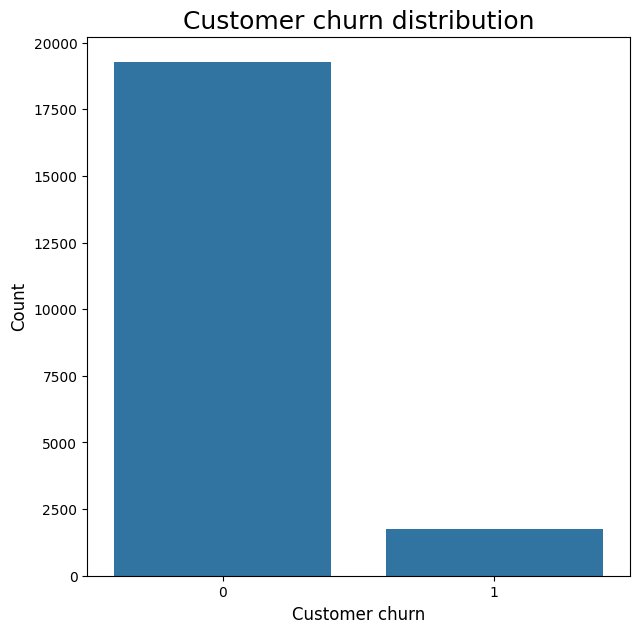

In [41]:
# Visualize churn distribution
plt.figure(figsize=(7, 7))
sns.countplot(x = high_val_train['churn_probability'])
plt.xlabel('Customer churn', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Customer churn distribution', fontsize=18)
plt.show()

#### Based on the visualization, it's evident that 91.73% of customers are non-churn, while 8.26% of customers churn. This indicates a noticeable class imbalance, which we will address later.

In [42]:
# Create a copy of high_val_train df and use the new df (churn_data) for pruning in the training set
churn_data = high_val_train.copy()
churn_data.reset_index(inplace=True)
churn_data.drop(['index'], axis=1, inplace=True)

In [43]:
churn_data.shape

(20998, 149)

In [44]:
# Get the list of columns with missing values in the training set
mv = round(100*(churn_data.isnull().sum(axis=0)/churn_data.shape[0]), 2)
s = mv.loc[mv>0]
impute_cols_num = list(s.index)
len(impute_cols_num)

81

In [45]:
# Lets try to verify how many values are missing from the dataframe
drop = high_val_train.dropna()
print(churn_data.shape[0] - drop.shape[0])

1061


### 2.5. Impute missing values using KNN Imputer - Training Set

We cannot discard these missing values because doing so would result in the loss of valuable information. Instead, we will employ imputation techniques such as KNNImputer.

KNNImputer is a technique used to impute missing values in a dataset based on the values of its nearest neighbors. It works by identifying the k nearest neighbors of each data point with missing values, then averaging or taking a weighted average of the available values from those neighbors to fill in the missing value. This approach leverages the similarity between data points to estimate the missing values more accurately

In [46]:
# Create imputer instance
imputer = KNNImputer(n_neighbors=5)

In [47]:
# Separate df having columns to be imputed
df_num = churn_data[impute_cols_num]
churn_df = churn_data.drop(impute_cols_num, axis=1)

In [48]:
# Impute using KNN imputer instance
df_imp = imputer.fit_transform(df_num)

In [49]:
# Convert it to df post imputation
df_imp = pd.DataFrame(df_imp, columns=impute_cols_num)
df_imp.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        21.28         4.83         6.13         56.99         38.11   
1        10.43        24.99       194.43        317.11        341.79   
2       859.53       372.71         0.89        293.46        450.11   
3        93.18        38.29        29.86        531.19        507.76   
4         8.58        11.48        12.68        133.16        158.73   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0          9.63          53.64            0.0            0.0          15.73   
1        197.09           0.00            0.0            0.0           0.00   
2        386.91           0.00            0.0            0.0           0.00   
3        222.03           0.00            0.0            0.0           0.00   
4        182.83           0.00            0.0            0.0           0.00   

   ...  std_ic_mou_8  spl_ic_mou_6  spl_ic_mou_7  spl_ic_mou_8  isd_ic_mou_6  \
0  ...          0.00          0.00           0.0           0.0           0.0   
1  ...          0.00          0.00           0.0           0.0           0.0   
2  ...          0.00          0.13           0.0           0.0           0.0   
3  ...         21.93          0.00           0.0           0.0           0.0   
4  ...          0.40          0.00           0.0           0.0           0.0   

   isd_ic_mou_7  isd_ic_mou_8  ic_others_6  ic_others_7  ic_others_8  
0           0.0           0.0          0.0         0.00          0.0  
1           0.0           0.0          0.0         0.00          0.0  
2           0.0           0.0          0.0         0.15          0.4  
3           0.0           0.0          0.0         0.00          0.0  
4           0.0           0.0          0.0         0.00          0.0  

[5 rows x 81 columns]

In [50]:
# Merge the two dataframes together post imputation to create the final training set
final_df = pd.concat([df_imp, churn_df], join='inner', axis=1)
final_df.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        21.28         4.83         6.13         56.99         38.11   
1        10.43        24.99       194.43        317.11        341.79   
2       859.53       372.71         0.89        293.46        450.11   
3        93.18        38.29        29.86        531.19        507.76   
4         8.58        11.48        12.68        133.16        158.73   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0          9.63          53.64            0.0            0.0          15.73   
1        197.09           0.00            0.0            0.0           0.00   
2        386.91           0.00            0.0            0.0           0.00   
3        222.03           0.00            0.0            0.0           0.00   
4        182.83           0.00            0.0            0.0           0.00   

   ...  fb_user_7  fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
0  ...        1.0        1.0   647         0.0        0.00        0.00   
1  ...       -1.0        1.0   602         0.0        0.00        0.00   
2  ...       -1.0       -1.0   455         0.0        0.00        0.00   
3  ...        0.0        0.0  1219         0.0        0.00        0.00   
4  ...        1.0        1.0   573       700.4      185.71      173.72   

   churn_probability  total_amt_6  total_amt_7  total_avg_amt_6_7  
0                  0       1515.0       1473.0             1494.0  
1                  0        808.0        400.0              604.0  
2                  0       1420.0        990.0             1205.0  
3                  0        463.0        519.0              491.0  
4                  0       1385.0       1180.0             1282.5  

[5 rows x 149 columns]

In [51]:
final_df.shape

(20998, 149)

In [52]:
# Verify no missing value is present in the training set now
final_df.isnull().sum().sort_values(ascending=False)

onnet_mou_6          0
total_rech_amt_7     0
max_rech_amt_6       0
max_rech_amt_7       0
max_rech_amt_8       0
                    ..
loc_ic_t2t_mou_8     0
loc_ic_t2m_mou_6     0
loc_ic_t2m_mou_7     0
loc_ic_t2m_mou_8     0
total_avg_amt_6_7    0
Length: 149, dtype: int64

### 2.6. Impute missing values using the KNN Imputer - Unseen Test Set

In [53]:
# Separate df having columns to be imputed
df_num_unseen = unseen[impute_cols_num]
churn_df_unseen = unseen.drop(impute_cols_num, axis=1)

In [54]:
# Impute using KNN imputer instance
df_imp_unseen = imputer.transform(df_num_unseen)

In [55]:
# Convert it to df post imputation
df_imp_unseen = pd.DataFrame(df_imp_unseen, columns=impute_cols_num)
df_imp_unseen.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        31.78        20.23        23.11         60.16         32.16   
1        75.51        41.21        19.84        474.34        621.84   
2         7.54         7.86         8.40         16.98         45.81   
3         5.31         2.16         0.00         40.04        205.01   
4       450.93       609.03       700.68         60.94         23.84   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0         34.83           0.00           0.00           0.00           0.00   
1        394.94           0.00           0.00           0.00           0.00   
2         45.04          22.81         103.38          26.08          24.53   
3         24.01           0.00           0.00           0.00           0.00   
4         74.16           0.00           0.00           0.00           0.00   

   ...  std_ic_mou_8  spl_ic_mou_6  spl_ic_mou_7  spl_ic_mou_8  isd_ic_mou_6  \
0  ...          4.34          0.54          0.34          0.39          0.00   
1  ...          0.00          0.00          0.00          0.00        114.63   
2  ...          0.00          0.00          0.00          0.00          0.00   
3  ...          8.83          0.00          0.00          0.00          0.00   
4  ...        141.48          0.00          0.00          0.00          0.00   

   isd_ic_mou_7  isd_ic_mou_8  ic_others_6  ic_others_7  ic_others_8  
0          0.00          0.00          0.0          0.0         0.00  
1        177.88         94.23          0.0          0.0         0.00  
2          0.00          0.00          0.0          0.0         0.00  
3          1.43          8.65          0.0          0.0         0.00  
4          0.00          0.00          0.0          0.0         0.16  

[5 rows x 81 columns]

In [56]:
# Merge the two dataframes together post imputation
final_unseen_df = pd.concat([df_imp_unseen, churn_df_unseen], join='inner', axis=1)
final_unseen_df.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        31.78        20.23        23.11         60.16         32.16   
1        75.51        41.21        19.84        474.34        621.84   
2         7.54         7.86         8.40         16.98         45.81   
3         5.31         2.16         0.00         40.04        205.01   
4       450.93       609.03       700.68         60.94         23.84   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0         34.83           0.00           0.00           0.00           0.00   
1        394.94           0.00           0.00           0.00           0.00   
2         45.04          22.81         103.38          26.08          24.53   
3         24.01           0.00           0.00           0.00           0.00   
4         74.16           0.00           0.00           0.00           0.00   

   ...  fb_user_6  fb_user_7  fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  \
0  ...       -1.0       -1.0       -1.0  1692        0.00        0.00   
1  ...       -1.0       -1.0       -1.0  2533        0.00        0.00   
2  ...       -1.0       -1.0       -1.0   277      525.61      758.41   
3  ...       -1.0       -1.0       -1.0  1244        0.00        0.00   
4  ...       -1.0       -1.0       -1.0   462        0.00        0.00   

   jun_vbc_3g  total_amt_6  total_amt_7  total_avg_amt_6_7  
0        0.00        103.0         90.0               96.5  
1        0.00        500.0        500.0              500.0  
2      241.84        500.0       1000.0              750.0  
3        0.00        110.0        260.0              185.0  
4        0.00        356.0        490.0              423.0  

[5 rows x 149 columns]

In [57]:
final_unseen_df.shape

(30000, 149)

In [58]:
# Verify no missing value is present in the test set now
final_unseen_df.isnull().sum().sort_values(ascending=False)

onnet_mou_6          0
total_rech_amt_6     0
total_rech_amt_8     0
max_rech_amt_6       0
max_rech_amt_7       0
                    ..
loc_ic_t2t_mou_8     0
loc_ic_t2m_mou_6     0
loc_ic_t2m_mou_7     0
loc_ic_t2m_mou_8     0
total_avg_amt_6_7    0
Length: 149, dtype: int64

#### There are no missing values in the dataset now. Let's perform Exploratory Data Analysis and Outlier Treatment.

### **3.Utility Methods**

In [59]:
def bar_graph(title, month, y_list, data):
    """
    Plot bar graphs for given data.

    This function plots bar graphs for each month's data based on the provided y-variables.
    It creates subplots for each month, with the corresponding y-variable plotted against 'churn_probability'.
    The title of each subplot includes the specified title along with the month name.

    Parameters:
    - title (str): Title of the plot.
    - month (list of str): List of month names.
    - y_list (list of str): List of y-variable names corresponding to each month.
    - data (DataFrame): DataFrame containing the data to be plotted.

    Returns:
    - None
    """
    plt.figure(figsize=(15, 10))

    for i, m in enumerate(month):
        plt.subplot(2, 3, i+1)
        plt.title(f'{title} for {m}')
        sns.barplot(x='churn_probability', y=y_list[i], data=data)

    plt.tight_layout()
    plt.show()

In [60]:
def handle_outliers(dataframe):
    """
    Applies outlier handling transformations to the values in the given DataFrame.

    Parameters:
    - dataframe (DataFrame): The DataFrame containing the values to be transformed.

    Returns:
    - transformed_values (list): A list containing the transformed values based on the specified conditions.
    """

    transformed_values = []
    for value in dataframe:
        if value <= 0:
            transformed_values.append(float(0))
        elif float(value) == float(1.0):
            transformed_values.append(float(1.5))
        else:
            transformed_values.append(float(np.log1p(value)))

    return transformed_values

In [61]:
def calculate_classification_metrics(y_true, y_pred):
    """
    Calculate various classification metrics.

    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.

    Returns:
    pd.DataFrame: A DataFrame containing the calculated metrics.
    """
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix')
    print()
    print(cm)

    # True Positives, False Positives, True Negatives, False Negatives
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    # Accuracy Score
    accuracy = round((TP + TN) / (TP + FP + TN + FN), 4)

    # Sensitivity (Recall or True Positive Rate)
    sensitivity = round(TP / (TP + FN), 4)

    # Specificity
    specificity = round(TN / (TN + FP), 4)

    # Precision
    precision = round(TP / (TP + FP), 4)

    # False Positive Rate
    false_positive_rate = round(FP / (FP + TN), 4)

    # True Positive Rate
    true_positive_rate = sensitivity

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'False Positive Rate', 'True Positive Rate'],
        'Value': [accuracy, sensitivity, specificity, precision, false_positive_rate, true_positive_rate]
    })

    return metrics_df

In [62]:
def draw_roc_curve(actual, probs):
    fpr, tpr, thresholds = roc_curve(actual, probs,drop_intermediate = False)
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

### **4. Exploratory Data Analysis (EDA)**

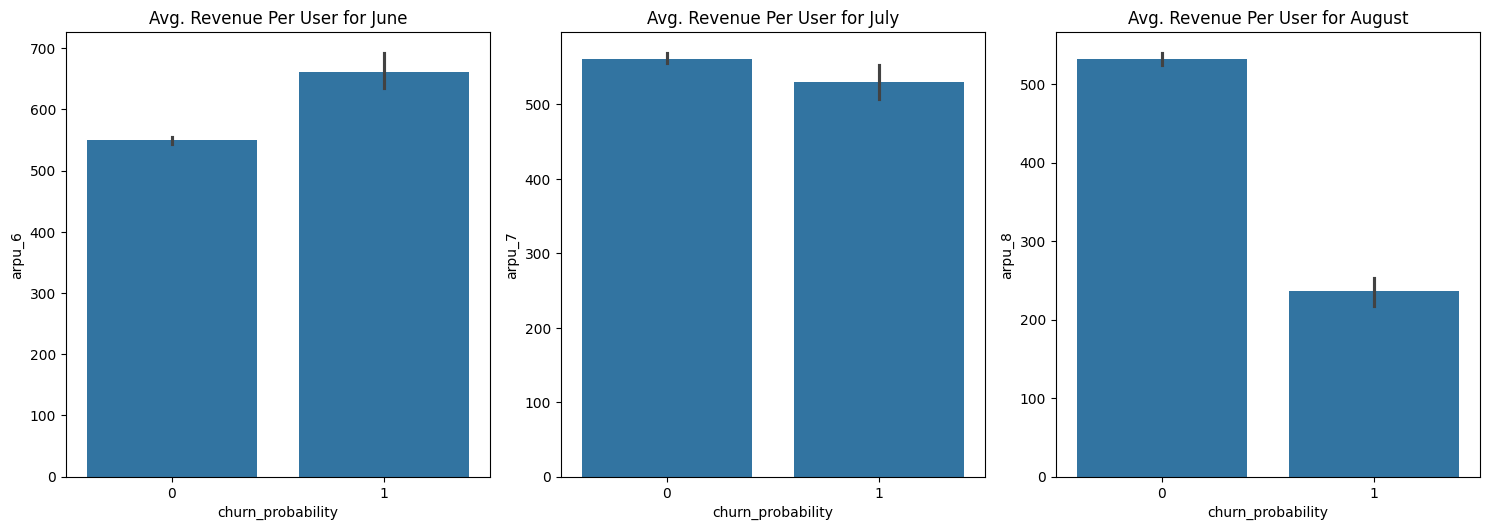

In [63]:
# Visualising Average Revenue per user
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8']
bar_graph('Avg. Revenue Per User', ['June', 'July', 'August'], arpu_cols, final_df)

##### The decline in the Average Revenue Per User (ARPU) in month of August suggests churn.

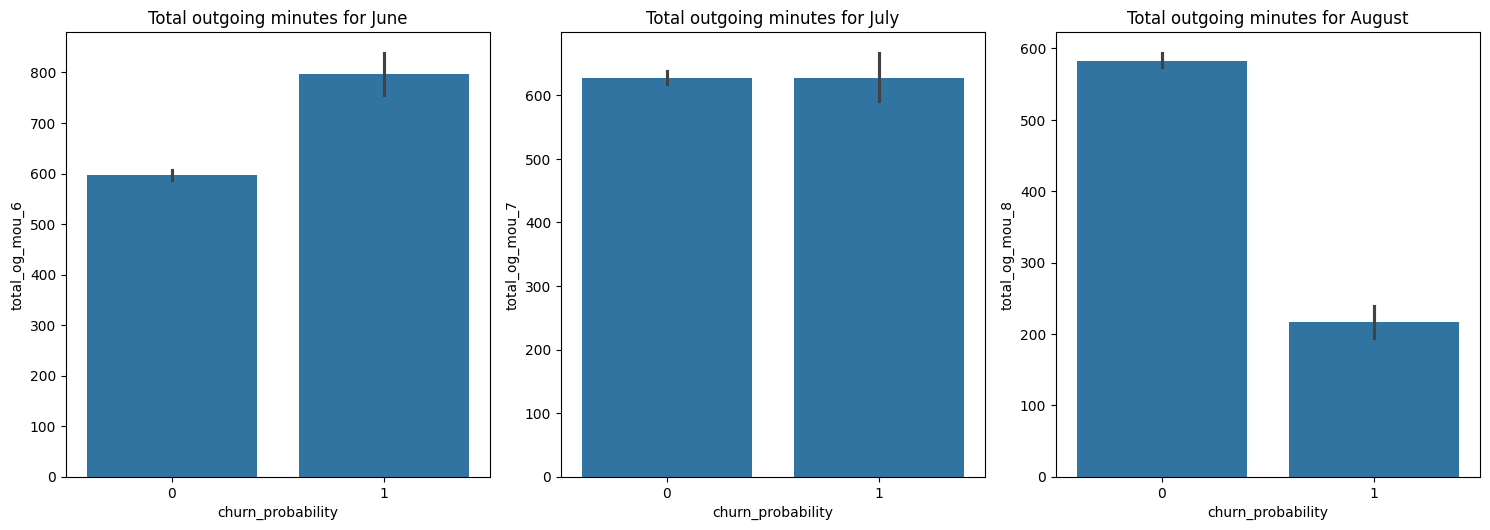

In [64]:
# Visualising Outgoing minutes of usage
total_og_mou_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
bar_graph('Total outgoing minutes', ['June', 'July', 'August'], total_og_mou_cols, final_df)

##### The decline in the Total outgoing minutes in month of August suggests churn.

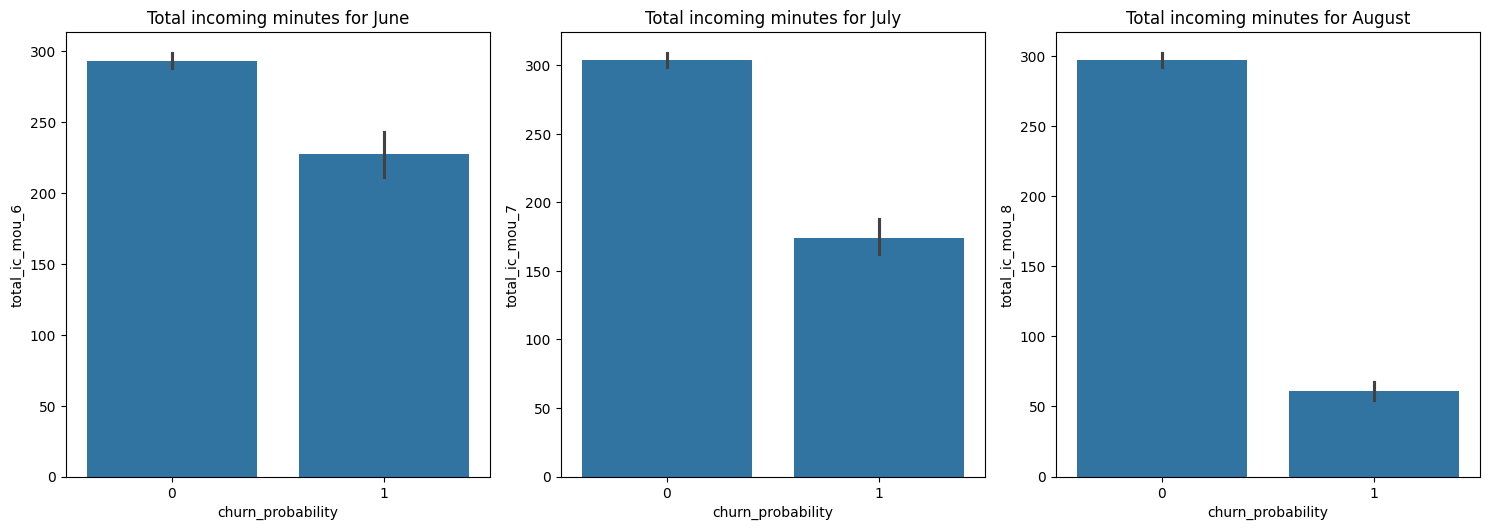

In [65]:
# Visualising incoming minutes of usage
total_ic_mou_cols = ['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']
bar_graph('Total incoming minutes', ['June', 'July', 'August'], total_ic_mou_cols, final_df)

##### The decline in the Total incoming minutes in month of August suggests churn.

In [66]:
# Analysing different metrics by extracting them into columns of similar type
amount_data = final_df.loc[:, final_df.columns.str.contains('amt')]
data2g = final_df.loc[:, final_df.columns.str.contains('2g')]
data3g = final_df.loc[:, final_df.columns.str.contains('3g')]
ic_mou_data = final_df.loc[:, final_df.columns.str.contains('ic') & final_df.columns.str.contains('mou')]
net_mou_data = final_df.loc[:, final_df.columns.str.contains('net_mou')]
og_mou_data = final_df.loc[:, final_df.columns.str.contains('og') & final_df.columns.str.contains('mou')]
rech_data = final_df.loc[:, final_df.columns.str.contains('rech')]
total_data = final_df.loc[:, final_df.columns.str.contains('tot')]

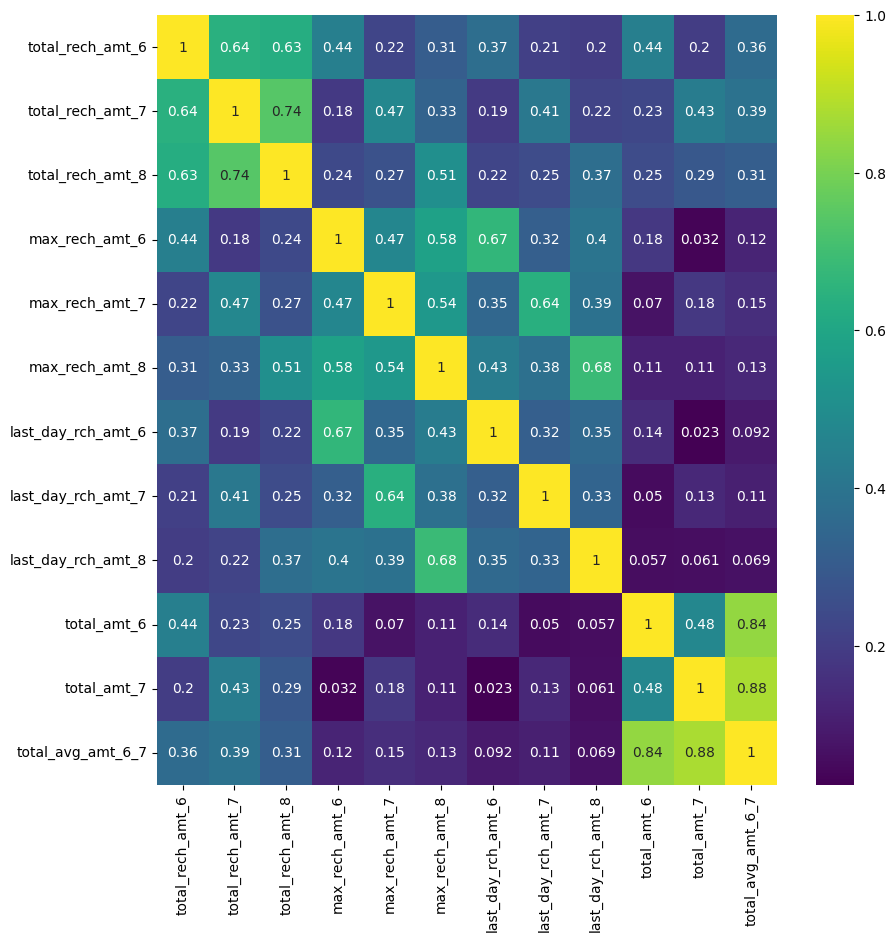

In [67]:
# Amount data
plt.figure(figsize=(10,10))
sns.heatmap(amount_data.corr(), annot=True, cmap='viridis')
plt.show()

***Observations:***
- A substantial correlation of 74% exists between the total recharge amount in month 7 and month 8.
- Similarly, a notable correlation of 68% is observed between the maximum recharge amount in month 8 and the last day's recharge amount in the same month.
- This suggests that customers who are unlikely to churn tend to recharge higher amounts in month 8.

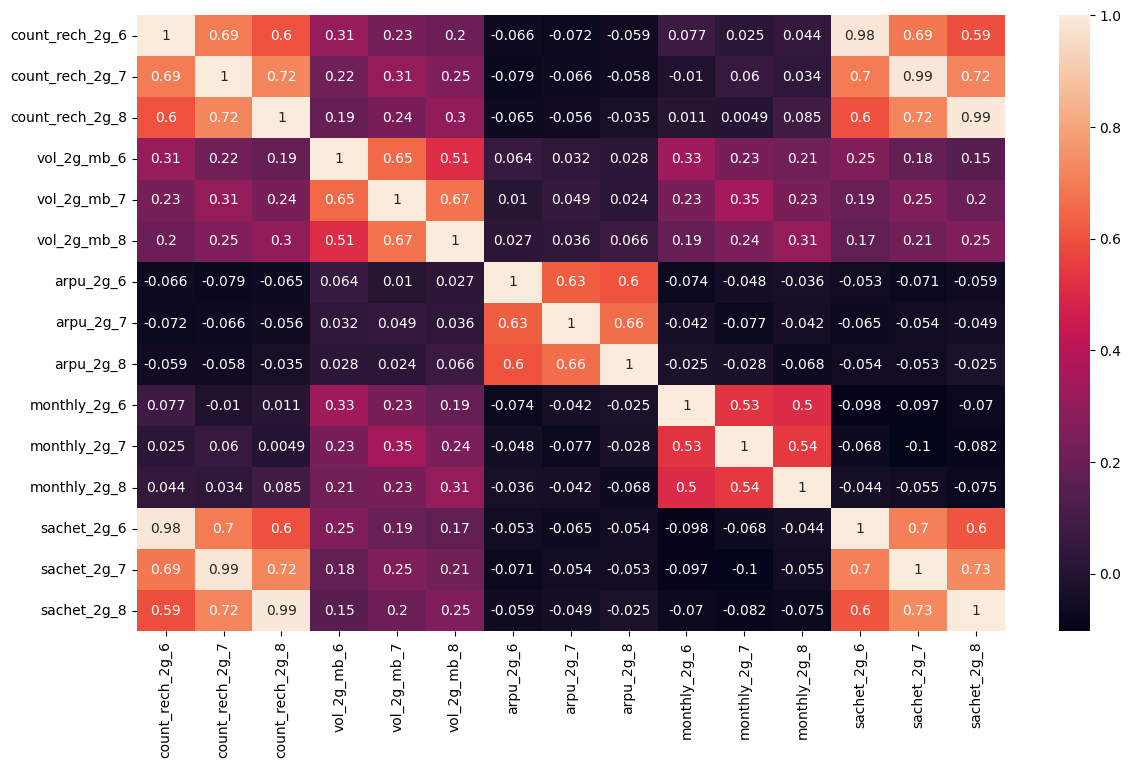

In [68]:
# 2G data
plt.figure(figsize=(14,8))
sns.heatmap(data2g.corr(), annot=True)
plt.show()

***Observations:***
- There is a strong correlation between recharge quantities in months 7 and 8.

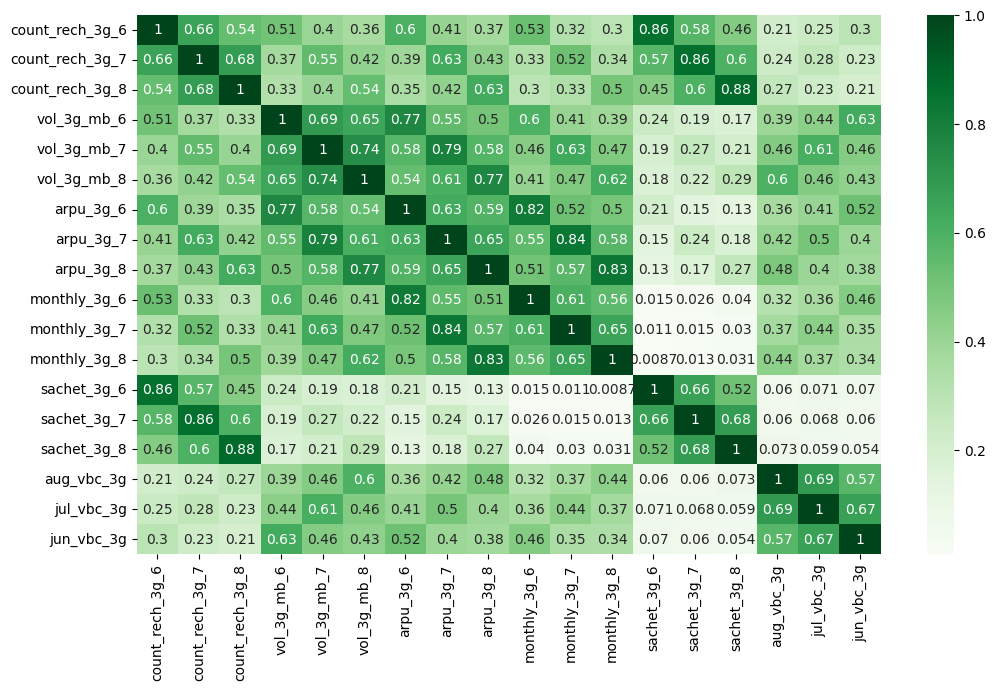

In [69]:
#3G Data
plt.figure(figsize=(12,7))
sns.heatmap(data3g.corr(),annot=True, cmap='Greens')
plt.show()

***Observations:***
- There is a strong correlation between recharge quantities in months 7 and 8.

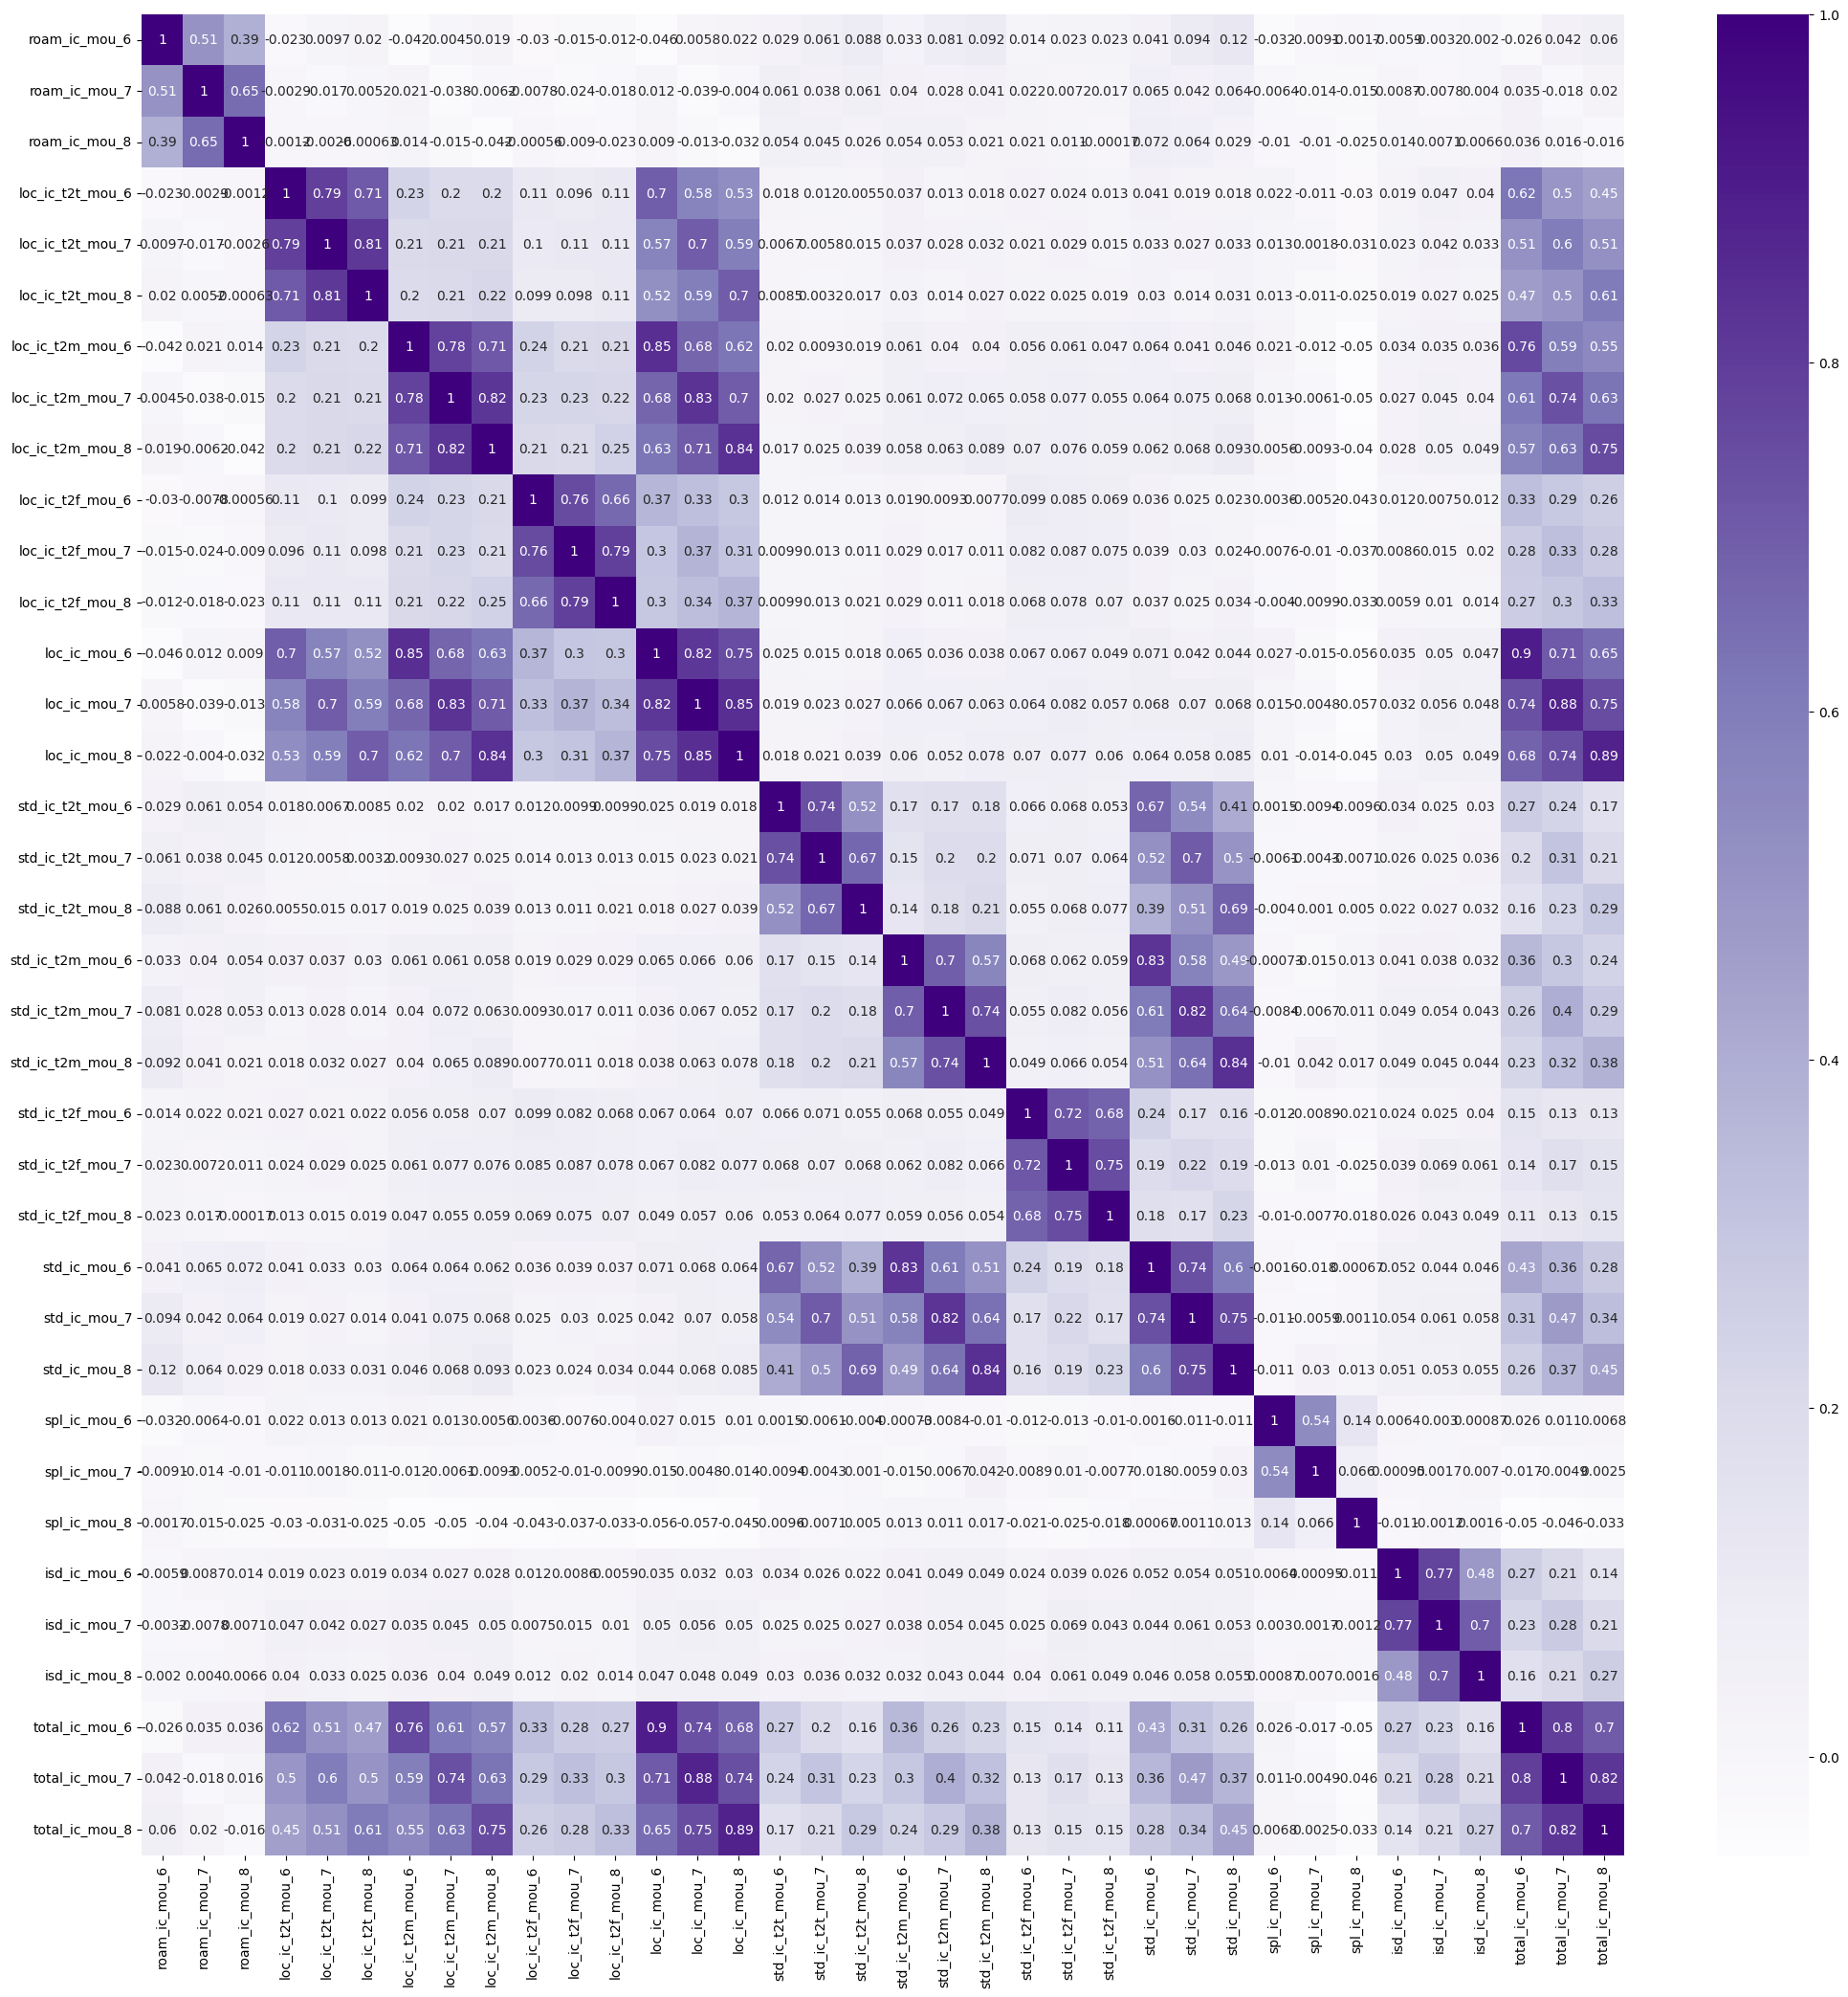

In [70]:
#ic_mou_data
plt.figure(figsize=(25, 25))
sns.heatmap(ic_mou_data.corr(), annot=True, cmap='Purples')
plt.show()

***Observations:*** <br/><br/>
The following variables or features exhibit a remarkably high correlation:

1. total_ic_mou_6 and loc_ic_mou_6
2. total_ic_mou_7 and loc_ic_mou_7
3. total_ic_mou_8 and loc_ic_mou_8
4. std_ic_mou_6 and std_ic_t2f_mou_6
5. std_ic_mou_7 and std_ic_t2f_mou_7
6. std_ic_mou_8 and std_ic_t2f_mou_8

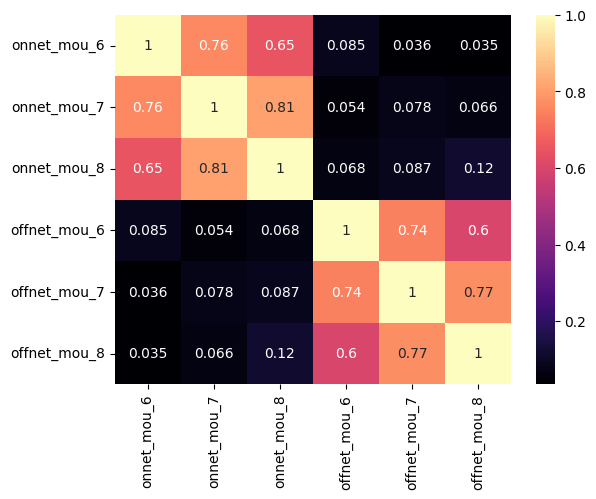

In [71]:
#net_mou_data
sns.heatmap(net_mou_data.corr(), annot=True, cmap='magma')
plt.show()

***Observations:***
- There is no correlation between the usage minutes for on-net and off-net calls.
- However, a significant correlation is observed between the on-net and off-net usage minutes in both months 7 and 8.

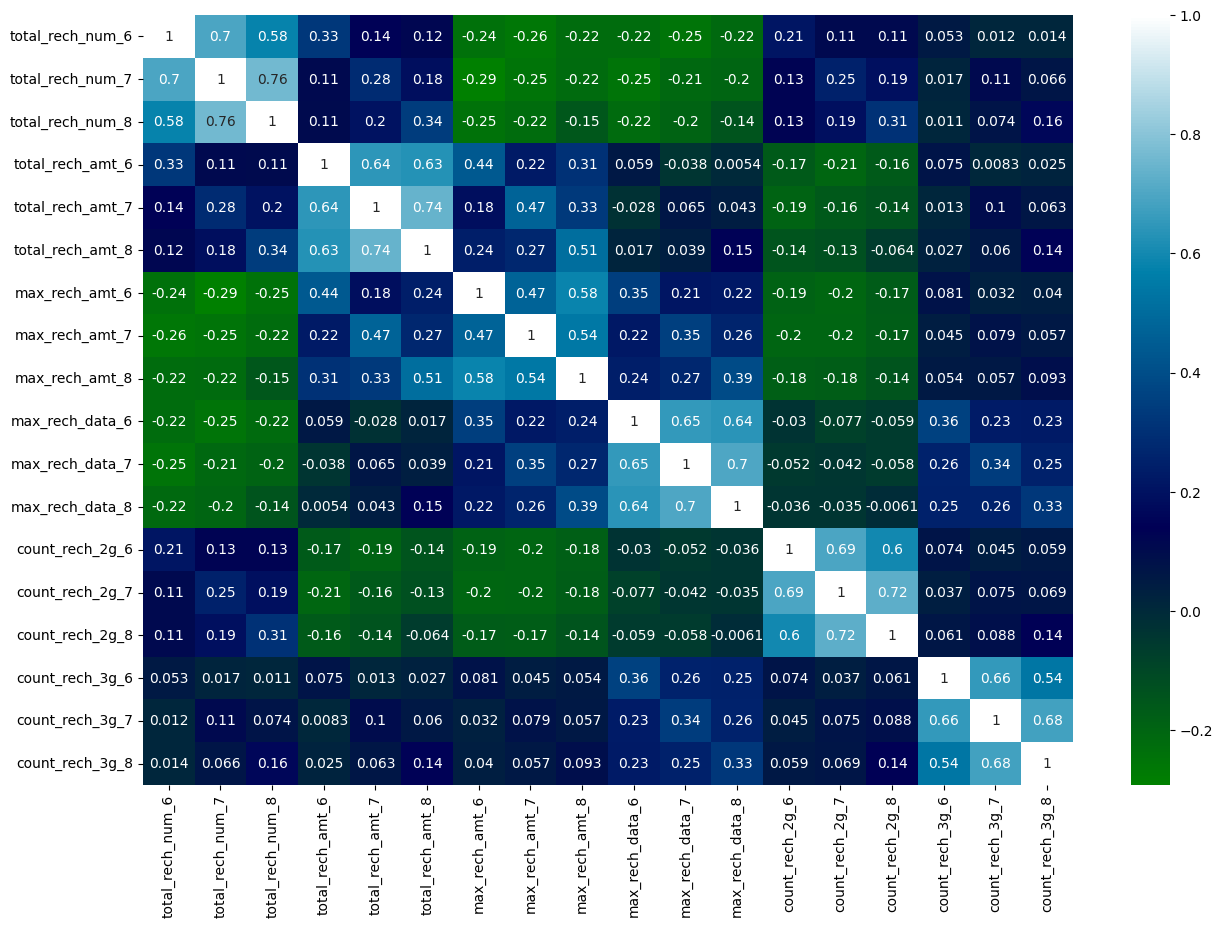

In [72]:
#rech_data
plt.figure(figsize=(15,10))
sns.heatmap(rech_data.corr(), annot=True, cmap='ocean')
plt.show()

***Observations:***
- There is a notable correlation between the average recharge amount and the recharge amount for both months 6 and 7.
- A significant correlation of 76% exists between the total recharge for month 7 and the recharge for month 8.
- Any factor correlated with month 8 is likely correlated with churn prediction.

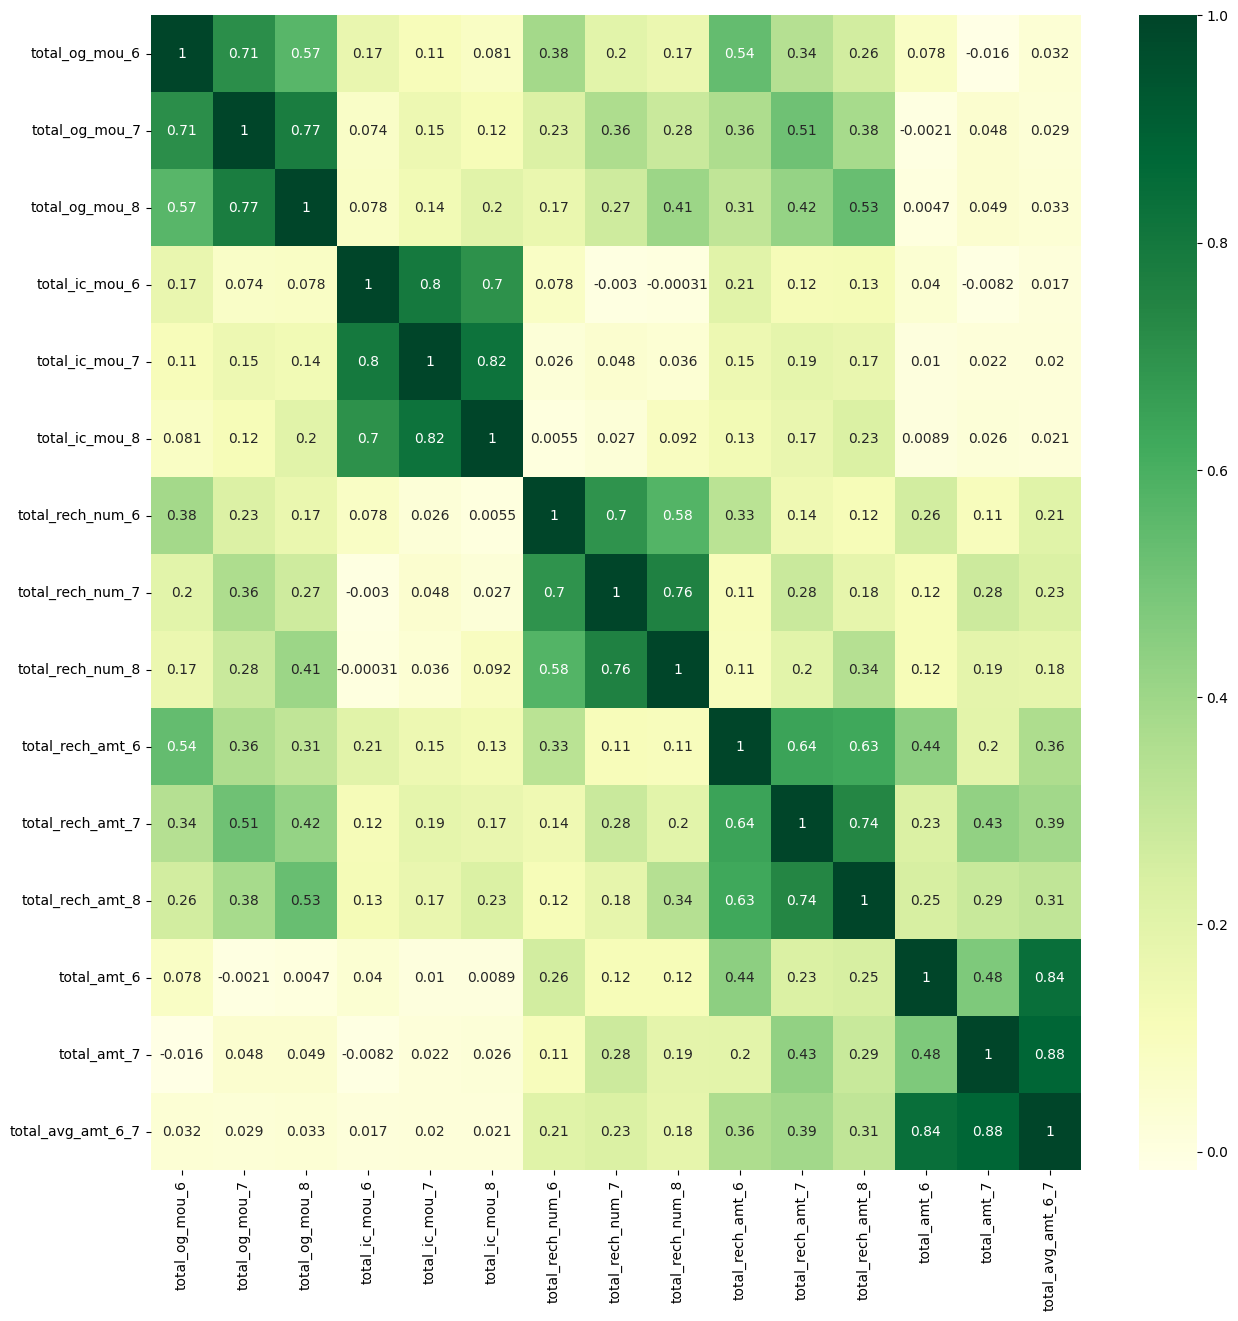

In [73]:
#total_data
plt.figure(figsize=(15,15))
sns.heatmap(total_data.corr(), annot=True, cmap='YlGn')
plt.show()

***Observations:***
- There exists a remarkably high correlation between the incoming (82%) and outgoing minutes (77%) of usage in months 7 and 8.
- Heavy usage suggests that customers are less likely to churn.

In [74]:
# Inspecting shape of the training dataset
final_df.shape

(20998, 149)

In [75]:
# Inspecting the shape of the test set
final_unseen_df.shape

(30000, 149)

### 5. Dummy Variable Creation - Training Set

In [76]:
# Creating dummies for categorical columns
dummy_df = pd.get_dummies(final_df[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')

In [77]:
final_df = pd.concat([final_df, dummy_df], axis=1)

In [78]:
# drop the category cols
final_df.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)

In [79]:
final_df.shape

(20998, 155)

### 6. Dummy Variable Creation - Test Set

In [80]:
# Creating dummies for categorical columns
dummy_unseen_df = pd.get_dummies(final_unseen_df[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')

In [81]:
final_unseen_df = pd.concat([final_unseen_df, dummy_unseen_df], axis=1)

In [82]:
# drop the category cols
final_unseen_df.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)

In [83]:
final_unseen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 155 entries, onnet_mou_6 to night_pck_user_6_1.0
dtypes: float64(117), int64(38)
memory usage: 35.5 MB


In [84]:
final_unseen_df.shape

(30000, 155)

### 7. Outlier Treatment

In [85]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
final_df.describe(percentiles=[.25, .50, .75, .90, .95, .99])

onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count  20998.000000  20998.000000  20998.000000  20998.000000  20998.000000   
mean     267.170793    272.100831    240.685694    382.262764    383.247937   
std      466.085572    486.515207    465.230750    480.518888    490.939567   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       19.440000     17.940000     13.815000     79.540000     75.790000   
50%       90.235000     87.830000     72.685000    234.680000    228.800000   
75%      292.127500    290.620000    245.405000    495.255000    498.790000   
90%      766.325000    788.211000    672.592000    912.390000    922.828000   
95%     1147.427500   1194.174500   1086.979500   1265.446000   1274.301500   
99%     2164.456000   2239.353000   2153.499100   2338.036700   2394.084300   
max     7376.710000   8157.780000  10752.560000   8362.360000   7043.980000   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
count  20998.000000   20998.000000   20998.000000   20998.000000   
mean     344.876263      16.405599      13.038984      12.474249   
std      476.342812      77.640327      77.874475      72.898547   
min        0.000000       0.000000       0.000000       0.000000   
25%       58.000000       0.000000       0.000000       0.000000   
50%      198.600000       0.000000       0.000000       0.000000   
75%      444.155500       0.000000       0.000000       0.000000   
90%      841.962000      28.202000      14.731000      15.916000   
95%     1172.576500      86.367500      56.947500      56.103500   
99%     2178.008900     335.603500     283.862000     276.136000   
max    14007.340000    2613.310000    3813.290000    4169.810000   

       roam_og_mou_6  ...  fb_user_8_0.0  fb_user_8_1.0  fb_user_7_0.0  \
count   20998.000000  ...   20998.000000   20998.000000   20998.000000   
mean       27.934132  ...       0.055624       0.476617       0.043433   
std       120.392034  ...       0.229200       0.499465       0.203834   
min         0.000000  ...       0.000000       0.000000       0.000000   
25%         0.000000  ...       0.000000       0.000000       0.000000   
50%         0.000000  ...       0.000000       0.000000       0.000000   
75%         0.000000  ...       0.000000       1.000000       0.000000   
90%        52.940000  ...       0.000000       1.000000       0.000000   
95%       154.087500  ...       1.000000       1.000000       0.000000   
99%       546.030900  ...       1.000000       1.000000       1.000000   
max      3775.110000  ...       1.000000       1.000000       1.000000   

       fb_user_7_1.0  fb_user_6_0.0  fb_user_6_1.0  night_pck_user_7_0.0  \
count   20998.000000   20998.000000   20998.000000          20998.000000   
mean        0.523955       0.039670       0.516811              0.554339   
std         0.499438       0.195188       0.499729              0.497050   
min         0.000000       0.000000       0.000000              0.000000   
25%         0.000000       0.000000       0.000000              0.000000   
50%         1.000000       0.000000       1.000000              1.000000   
75%         1.000000       0.000000       1.000000              1.000000   
90%         1.000000       0.000000       1.000000              1.000000   
95%         1.000000       0.000000       1.000000              1.000000   
99%         1.000000       1.000000       1.000000              1.000000   
max         1.000000       1.000000       1.000000              1.000000   

       night_pck_user_7_1.0  night_pck_user_6_0.0  night_pck_user_6_1.0  
count          20998.000000          20998.000000          20998.000000  
mean               0.013049              0.543290              0.013192  
std                0.113487              0.498134              0.114098  
min                0.000000              0.000000              0.000000  
25%                0.000000              0.000000              0.00000

In [86]:
numerical_cols = list(final_df.select_dtypes(exclude='category'))
numerical_cols

['onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou

##### The `handle_outliers` method treats outliers and adjusts skewness in the dataset to improve data robustness and analysis accuracy.

In [87]:
# Handle outliers of numerical columns in the training set
final_df[numerical_cols] = final_df[numerical_cols].apply(handle_outliers)

In [88]:
# Inspecting the numerical columns again in the training set
final_df.describe(percentiles=[.25, .50, .75, .90, .95, .99])

onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count  20998.000000  20998.000000  20998.000000  20998.000000  20998.000000   
mean       4.211139      4.187525      3.998177      5.094078      5.069483   
std        2.016294      2.044529      2.066726      1.674873      1.700992   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.017494      2.941276      2.695640      4.388754      4.341074   
50%        4.513439      4.486724      4.299799      5.462475      5.437209   
75%        5.680608      5.675452      5.506977      6.207090      6.214188   
90%        6.642910      6.671034      6.512625      6.817163      6.828526   
95%        7.046149      7.086047      6.992078      7.143970      7.150938   
99%        7.680386      7.714389      7.675314      7.757494      7.781174   
max        8.906219      9.006850      9.282992      9.031616      8.860071   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
count  20998.000000   20998.000000   20998.000000   20998.000000   
mean       4.867771       0.714730       0.566267       0.595661   
std        1.803701       1.516128       1.366637       1.367898   
min        0.000000       0.000000       0.000000       0.000000   
25%        4.077537       0.000000       0.000000       0.000000   
50%        5.296315       0.000000       0.000000       0.000000   
75%        6.098424       0.000000       0.000000       0.000000   
90%        6.736922       3.374237       2.755631       2.828260   
95%        7.067811       4.470123       4.059537       4.044865   
99%        7.686625       5.818906       5.652004       5.624508   
max        9.547408       7.868755       8.246510       8.335866   

       roam_og_mou_6  ...  fb_user_8_0.0  fb_user_8_1.0  fb_user_7_0.0  \
count   20998.000000  ...   20998.000000   20998.000000   20998.000000   
mean        0.835726  ...       0.083437       0.714925       0.065149   
std         1.728676  ...       0.343800       0.749197       0.305751   
min         0.000000  ...       0.000000       0.000000       0.000000   
25%         0.000000  ...       0.000000       0.000000       0.000000   
50%         0.000000  ...       0.000000       0.000000       0.000000   
75%         0.000000  ...       0.000000       1.500000       0.000000   
90%         3.987872  ...       0.000000       1.500000       0.000000   
95%         5.043989  ...       1.500000       1.500000       0.000000   
99%         6.304505  ...       1.500000       1.500000       1.500000   
max         8.236450  ...       1.500000       1.500000       1.500000   

       fb_user_7_1.0  fb_user_6_0.0  fb_user_6_1.0  night_pck_user_7_0.0  \
count   20998.000000   20998.000000   20998.000000          20998.000000   
mean        0.785932       0.059506       0.775217              0.831508   
std         0.749157       0.292783       0.749594              0.745576   
min         0.000000       0.000000       0.000000              0.000000   
25%         0.000000       0.000000       0.000000              0.000000   
50%         1.500000       0.000000       1.500000              1.500000   
75%         1.500000       0.000000       1.500000              1.500000   
90%         1.500000       0.000000       1.500000              1.500000   
95%         1.500000       0.000000       1.500000              1.500000   
99%         1.500000       1.500000       1.500000              1.500000   
max         1.500000       1.500000       1.500000              1.500000   

       night_pck_user_7_1.0  night_pck_user_6_0.0  night_pck_user_6_1.0  
count          20998.000000          20998.000000          20998.000000  
mean               0.019573              0.814935              0.019788  
std                0.170230              0.747201              0.171147  
min                0.000000              0.000000              0.000000  
25%                0.000000              0.000000              0.00000

In [89]:
# Handle outliers of numerical columns in the test set
final_unseen_df[numerical_cols] = final_unseen_df[numerical_cols].apply(handle_outliers)

In [90]:
# Inspecting the numerical columns again in the training set
final_unseen_df.describe(percentiles=[.25, .50, .75, .90, .95, .99])

onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean       3.455662      3.399474      3.378267      4.370298      4.322030   
std        1.920246      1.947314      1.946923      1.640813      1.665584   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.163093      2.059239      2.033070      3.599775      3.514824   
50%        3.633895      3.548640      3.540089      4.616011      4.552297   
75%        4.848802      4.825109      4.816605      5.502207      5.462984   
90%        5.875610      5.865638      5.844396      6.167812      6.173644   
95%        6.432364      6.435466      6.414786      6.575421      6.609280   
99%        7.232457      7.293730      7.295839      7.326309      7.341630   
max        8.845829      8.910857      8.813556      8.848432      9.176590   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
count  30000.000000   30000.000000   30000.000000   30000.000000   
mean       4.293024       0.573719       0.434661       0.448419   
std        1.681242       1.293450       1.124307       1.149469   
min        0.000000       0.000000       0.000000       0.000000   
25%        3.480932       0.000000       0.000000       0.000000   
50%        4.548917       0.000000       0.000000       0.000000   
75%        5.454723       0.000000       0.000000       0.000000   
90%        6.175986       2.811088       2.136767       2.236445   
95%        6.578942       3.724247       3.162581       3.262414   
99%        7.322517       5.383877       5.045232       5.110086   
max        9.514056       9.527002       9.640306       9.480090   

       roam_og_mou_6  ...  fb_user_8_0.0  fb_user_8_1.0  fb_user_7_0.0  \
count   30000.000000  ...    30000.00000   30000.000000    30000.00000   
mean        0.672716  ...        0.04280       0.353300        0.03585   
std         1.457952  ...        0.24974       0.636508        0.22911   
min         0.000000  ...        0.00000       0.000000        0.00000   
25%         0.000000  ...        0.00000       0.000000        0.00000   
50%         0.000000  ...        0.00000       0.000000        0.00000   
75%         0.000000  ...        0.00000       0.000000        0.00000   
90%         3.360811  ...        0.00000       1.500000        0.00000   
95%         4.270851  ...        0.00000       1.500000        0.00000   
99%         5.612934  ...        1.50000       1.500000        1.50000   
max         7.680841  ...        1.50000       1.500000        1.50000   

       fb_user_7_1.0  fb_user_6_0.0  fb_user_6_1.0  night_pck_user_7_0.0  \
count   30000.000000   30000.000000   30000.000000          30000.000000   
mean        0.349450       0.034150       0.345100              0.377350   
std         0.634092       0.223742       0.631323              0.650881   
min         0.000000       0.000000       0.000000              0.000000   
25%         0.000000       0.000000       0.000000              0.000000   
50%         0.000000       0.000000       0.000000              0.000000   
75%         0.000000       0.000000       0.000000              1.500000   
90%         1.500000       0.000000       1.500000              1.500000   
95%         1.500000       0.000000       1.500000              1.500000   
99%         1.500000       1.500000       1.500000              1.500000   
max         1.500000       1.500000       1.500000              1.500000   

       night_pck_user_7_1.0  night_pck_user_6_0.0  night_pck_user_6_1.0  
count          30000.000000          30000.000000          30000.000000  
mean               0.007950              0.369900              0.009350  
std                0.108914              0.646559              0.118059  
min                0.000000              0.000000              0.000000  
25%                0.000000              0.000000              0.00000

### **8. Model Building and Evaluation**

#### Train-Test Split

Given the availability of the `test.csv` file for testing purposes, this train-test split will exclusively operate on the `train.csv` dataset. It involves allocating 80% of the data for training and 20% for validation.

In [91]:
# Partitioning the dataset into the feature variable 'X' and the response variable 'y'.
X = final_df.drop(['churn_probability'], axis=1)
y = final_df['churn_probability']

In [92]:
X.shape

(20998, 154)

In [93]:
y.shape

(20998,)

In [94]:
X.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0     3.103689     1.763017     1.964311      4.060271      3.666378   
1     2.436241     3.257712     5.275202      5.762397      5.837118   
2     6.757548     5.923480     0.636577      5.685143      6.111711   
3     4.545208     3.670970     3.429461      6.277001      6.231976   
4     2.259678     2.524127     2.615935      4.899033      5.073485   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0      2.363680       4.000766            0.0            0.0       2.817204   
1      5.288721       0.000000            0.0            0.0       0.000000   
2      5.960773       0.000000            0.0            0.0       0.000000   
3      5.407306       0.000000            0.0            0.0       0.000000   
4      5.214011       0.000000            0.0            0.0       0.000000   

   ...  fb_user_8_0.0  fb_user_8_1.0  fb_user_7_0.0  fb_user_7_1.0  \
0  ...            0.0            1.5            0.0            1.5   
1  ...            0.0            1.5            0.0            0.0   
2  ...            0.0            0.0            0.0            0.0   
3  ...            1.5            0.0            1.5            0.0   
4  ...            0.0            1.5            0.0            1.5   

   fb_user_6_0.0  fb_user_6_1.0  night_pck_user_7_0.0  night_pck_user_7_1.0  \
0            0.0            1.5                   1.5                   0.0   
1            0.0            1.5                   0.0                   0.0   
2            0.0            0.0                   0.0                   0.0   
3            1.5            0.0                   1.5                   0.0   
4            0.0            1.5                   1.5                   0.0   

   night_pck_user_6_0.0  night_pck_user_6_1.0  
0                   1.5                   0.0  
1                   1.5                   0.0  
2                   0.0                   0.0  
3                   1.5                   0.0  
4                   1.5                   0.0  

[5 rows x 154 columns]

In [95]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: churn_probability, dtype: category
Categories (2, int64): [0, 1]

In [96]:
# Train test split - 80% training data, 20% validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=100)

In [97]:
# Checking the shape after split
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_val Shape:', X_val.shape)
print('y_val Shape:', y_val.shape)

X_train Shape: (16798, 154)
y_train Shape: (16798,)
X_val Shape: (4200, 154)
y_val Shape: (4200,)


In [98]:
y_train.value_counts()

churn_probability
0    15400
1     1398
Name: count, dtype: int64

### 8.1. Handling Data Imbalance using Synthetic Minority Over-sampling Technique (SMOTE)

In [99]:
smt = SMOTE(random_state=2)
X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)

In [100]:
X_train_smote.shape

(30800, 154)

In [101]:
y_train_smote.shape

(30800,)

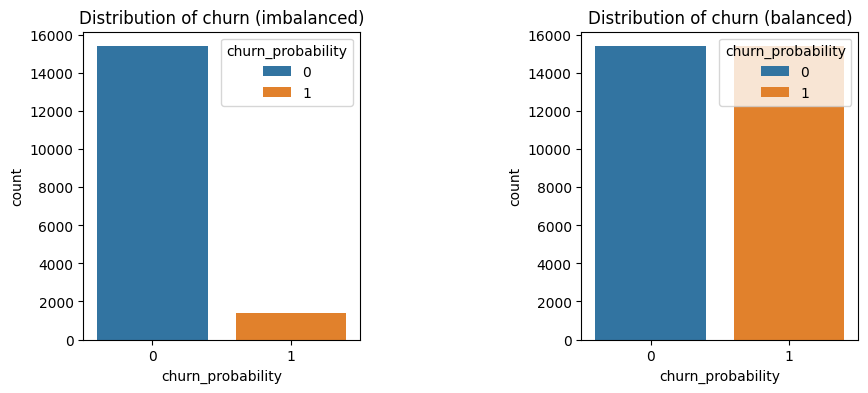

In [102]:
# Checking the distribution on our target variable 'y_train' before and after SMOTE
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.title("Distribution of churn (imbalanced)")
sns.countplot(x=y_train, hue=y_train)

plt.subplot(1,2,2)
plt.title("Distribution of churn (balanced)")
sns.countplot(x=y_train_smote, hue=y_train_smote)

plt.subplots_adjust(wspace=0.8)
plt.show()

##### Now the data imbalance issue is sorted.

### 8.2. Feature Scaling using SandardScaler - Training Set

In [103]:
# Use SandardScaler to scale values
scaler = StandardScaler()

# Fit and transform training set
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_smote), columns = X_train_smote.columns, index = X_train_smote.index)

# Only Transform validation set
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns, index = X_val.index)

In [104]:
X_train_scaled.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0     0.149097     0.096313     0.612506     -0.131917     -0.127232   
1    -0.011491     0.097480     0.221881     -0.168733     -0.384974   
2     1.347333     1.161160     1.273533     -0.123081     -0.561949   
3     0.575350     0.440487     0.779006      1.168985      1.270926   
4     1.177194     1.567885     1.767955      0.643104     -0.114263   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0      0.241259       2.442332      -0.530507       2.266093       2.179343   
1      0.112299       0.953739      -0.530507       1.403829       1.516741   
2     -0.429040      -0.527310      -0.530507      -0.665387      -0.547857   
3      1.305694      -0.527310      -0.530507      -0.665387      -0.547857   
4      0.279905      -0.527310      -0.530507      -0.665387      -0.547857   

   ...  fb_user_8_0.0  fb_user_8_1.0  fb_user_7_0.0  fb_user_7_1.0  \
0  ...      -0.246405       1.498577      -0.209151      -0.882333   
1  ...      -0.246405      -0.683643      -0.209151      -0.882333   
2  ...      -0.246405      -0.683643      -0.209151      -0.882333   
3  ...      -0.246405       1.498577      -0.209151       1.162058   
4  ...      -0.246405       1.498577      -0.209151       1.162058   

   fb_user_6_0.0  fb_user_6_1.0  night_pck_user_7_0.0  night_pck_user_7_1.0  \
0      -0.208259       1.083555             -0.936624             -0.109314   
1      -0.208259      -0.946637             -0.936624             -0.109314   
2      -0.208259      -0.946637             -0.936624             -0.109314   
3      -0.208259       1.083555              1.104365             -0.109314   
4      -0.208259       1.083555             -0.936624             10.125927   

   night_pck_user_6_0.0  night_pck_user_6_1.0  
0              1.043735             -0.133862  
1             -0.998620             -0.133862  
2             -0.998620             -0.133862  
3              1.043735             -0.133862  
4             -0.998620              8.908799  

[5 rows x 154 columns]

### 8.3. Feature Scaling using StandardScaler - Unseen Test Set

In [105]:
final_unseen_df.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0     3.489819     3.055415     3.182627      4.113493      3.501344   
1     4.337421     3.742657     3.036874      6.164030      6.434290   
2     2.144761     2.181547     2.240710      2.889260      3.846097   
3     1.842136     1.150572     0.000000      3.714547      5.327925   
4     6.113527     6.413508     6.553477      4.126166      3.212455   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0      3.578786       0.000000       0.000000       0.000000       0.000000   
1      5.981263       0.000000       0.000000       0.000000       0.000000   
2      3.829511       3.170106       4.648038       3.298795       3.239854   
3      3.219276       0.000000       0.000000       0.000000       0.000000   
4      4.319619       0.000000       0.000000       0.000000       0.000000   

   ...  fb_user_8_0.0  fb_user_8_1.0  fb_user_7_0.0  fb_user_7_1.0  \
0  ...            0.0            0.0            0.0            0.0   
1  ...            0.0            0.0            0.0            0.0   
2  ...            0.0            0.0            0.0            0.0   
3  ...            0.0            0.0            0.0            0.0   
4  ...            0.0            0.0            0.0            0.0   

   fb_user_6_0.0  fb_user_6_1.0  night_pck_user_7_0.0  night_pck_user_7_1.0  \
0            0.0            0.0                   0.0                   0.0   
1            0.0            0.0                   0.0                   0.0   
2            0.0            0.0                   0.0                   0.0   
3            0.0            0.0                   0.0                   0.0   
4            0.0            0.0                   0.0                   0.0   

   night_pck_user_6_0.0  night_pck_user_6_1.0  
0                   0.0                   0.0  
1                   0.0                   0.0  
2                   0.0                   0.0  
3                   0.0                   0.0  
4                   0.0                   0.0  

[5 rows x 155 columns]

In [106]:
final_unseen_df.set_index('id', inplace=True)

### Model 1. Logistic Regression with Recursive Feature Elimination (RFE)

In [107]:
# Select top 20 features using RFE
logreg = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
rfe = RFE(logreg, n_features_to_select=20)
rfe = rfe.fit(X_train_scaled, y_train_smote)

In [108]:
list(zip(X_train_scaled.columns, rfe.support_, rfe.ranking_))

[('onnet_mou_6', False, 59),
 ('onnet_mou_7', False, 26),
 ('onnet_mou_8', False, 25),
 ('offnet_mou_6', False, 92),
 ('offnet_mou_7', False, 16),
 ('offnet_mou_8', False, 13),
 ('roam_ic_mou_6', False, 69),
 ('roam_ic_mou_7', False, 34),
 ('roam_ic_mou_8', True, 1),
 ('roam_og_mou_6', False, 68),
 ('roam_og_mou_7', False, 28),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 94),
 ('loc_og_t2t_mou_7', False, 66),
 ('loc_og_t2t_mou_8', False, 74),
 ('loc_og_t2m_mou_6', False, 22),
 ('loc_og_t2m_mou_7', False, 36),
 ('loc_og_t2m_mou_8', False, 23),
 ('loc_og_t2f_mou_6', False, 119),
 ('loc_og_t2f_mou_7', False, 38),
 ('loc_og_t2f_mou_8', False, 37),
 ('loc_og_t2c_mou_6', False, 79),
 ('loc_og_t2c_mou_7', False, 129),
 ('loc_og_t2c_mou_8', False, 109),
 ('loc_og_mou_6', False, 21),
 ('loc_og_mou_7', False, 15),
 ('loc_og_mou_8', False, 14),
 ('std_og_t2t_mou_6', False, 32),
 ('std_og_t2t_mou_7', False, 27),
 ('std_og_t2t_mou_8', False, 24),
 ('std_og_t2m_mou_6', False, 33),
 ('s

In [109]:
# Selected features using RFE
selected_features = X_train_scaled.columns[rfe.support_]
selected_features

Index(['roam_ic_mou_8', 'roam_og_mou_8', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
       'loc_ic_mou_7', 'loc_ic_mou_8', 'spl_ic_mou_8', 'total_ic_mou_8',
       'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6',
       'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'max_rech_data_8', 'count_rech_2g_8',
       'night_pck_user_8_0.0'],
      dtype='object')

In [110]:
X_train_scaled_final = X_train_scaled[selected_features]
logreg.fit(X_train_scaled_final, y_train_smote)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [111]:
y_train_smote_pred = logreg.predict(X_train_scaled_final)

In [112]:
# Calculate metrics on the training set
calculate_classification_metrics(y_train_smote, y_train_smote_pred)

Confusion Matrix

[[13532  1868]
 [ 2540 12860]]


Metric   Value
0             Accuracy  0.8569
1          Sensitivity  0.8351
2          Specificity  0.8787
3            Precision  0.8732
4  False Positive Rate  0.1213
5   True Positive Rate  0.8351

In [113]:
# Retain only the selected feature from the final model
X_val_scaled_final = X_val_scaled[selected_features]
X_val_scaled_final.head()

roam_ic_mou_8  roam_og_mou_8  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
3837       -0.665387      -0.710456         -0.630131         -0.290168   
11055      -0.665387      -0.710456         -1.797907         -1.503523   
12221      -0.665387      -0.710456         -0.936458          0.500096   
17179       0.507003       0.310656         -1.797907         -1.503523   
16047      -0.665387      -0.710456          1.009888          1.293739   

       loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_mou_7  loc_ic_mou_8  \
3837          -1.557462         -0.780535     -1.260499     -0.619060   
11055         -2.375158         -1.877587     -2.594398     -1.984767   
12221         -1.291162         -0.008022     -1.288229      0.116259   
17179         -2.375158         -1.877587     -2.594398     -1.984767   
16047          0.136627          0.558739      0.498659      0.815106   

       spl_ic_mou_8  total_ic_mou_8  total_rech_num_7  total_rech_num_8  \
3837      -0.266206       -0.300154         -1.082799         -0.101475   
11055      2.474225       -1.317514         -1.434322         -0.619858   
12221      6.933130        0.329095          0.159277          1.437791   
17179     -0.266206       -1.395256          0.159277         -0.101475   
16047     -0.266206        0.859190         -1.887514         -0.987657   

       total_rech_amt_6  total_rech_amt_8  max_rech_amt_6  max_rech_amt_8  \
3837           0.204074          0.547510        0.794832        0.902878   
11055          0.035264          0.561889        0.794832        0.902878   
12221         -5.086412          0.669800       -4.510459        0.156583   
17179          0.347429         -0.539241        0.004934       -0.256881   
16047          0.431105         -1.678770        1.078205       -1.675565   

       last_day_rch_amt_8  max_rech_data_8  count_rech_2g_8  \
3837            -1.039975         1.790895        -0.595224   
11055           -1.039975         1.790895        -0.595224   
12221            0.724532        -0.735593        -0.595224   
17179           -1.039975        -0.735593        -0.595224   
16047           -1.039975        -0.735593        -0.595224   

       night_pck_user_8_0.0  
3837               1.363391  
11055              1.363391  
12221             -0.759323  
17179             -0.759323  
16047             -0.759323

In [114]:
# Get the predicted values from the linear model
y_val_pred = logreg.predict(X_val_scaled_final)

In [115]:
confusion = confusion_matrix(y_true=y_val, y_pred=y_val_pred)
print(confusion)

[[3379  484]
 [  76  261]]


In [116]:
# Calculate metrics
metrics_df = calculate_classification_metrics(y_true=y_val, y_pred=y_val_pred)
metrics_df

Confusion Matrix

[[3379  484]
 [  76  261]]


Metric   Value
0             Accuracy  0.8667
1          Sensitivity  0.7745
2          Specificity  0.8747
3            Precision  0.3503
4  False Positive Rate  0.1253
5   True Positive Rate  0.7745

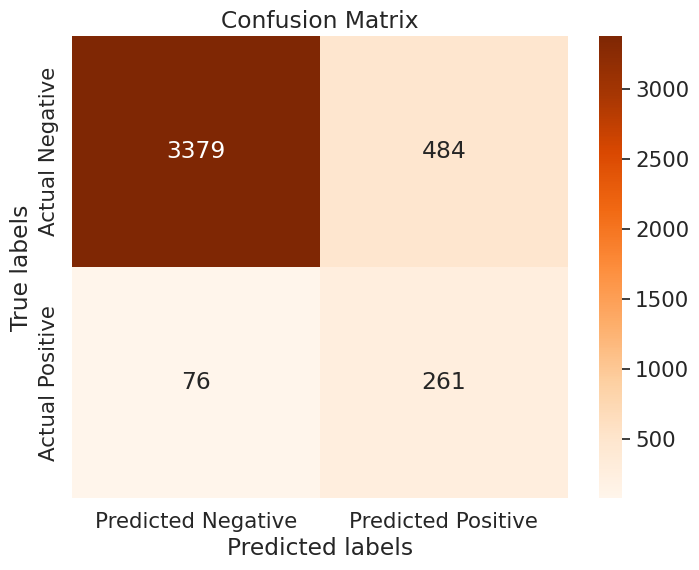

In [117]:
# Define labels for the confusion matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Reshape the confusion matrix into a 2x2 array
cm_array = np.array(confusion).reshape(2,2)

# Create the heatmap
plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(cm_array, annot=True, cmap='Oranges', fmt='g', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

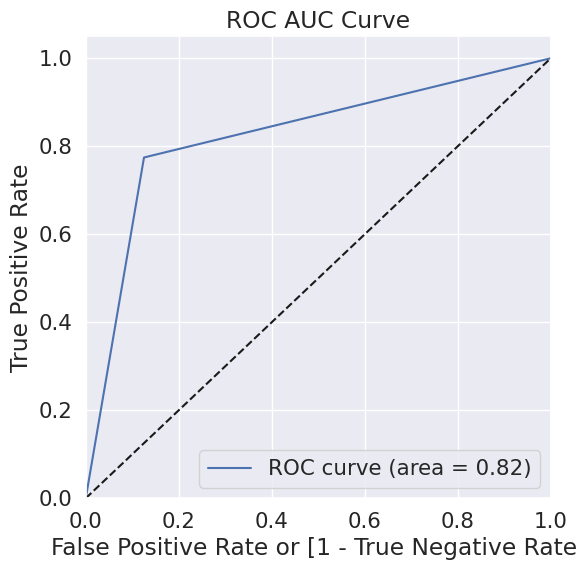

In [118]:
# ROC curve
fpr, tpr, thresholds = draw_roc_curve(y_val, y_val_pred)

In [119]:
# ROC AUC Score
"{:2.2f}".format(roc_auc_score(y_val, y_val_pred))

'0.82'

### Model 2. Logistic Regression with PCA and Hyperparameter Tuning

In [120]:
pca = PCA()

In [121]:
pca_components = pca.fit_transform(X_train)
pca_components

array([[ 4.89085664e-01,  2.83715755e+00,  3.62035943e+00, ...,
         3.52634588e-14, -9.43689571e-16, -2.11341361e-14],
       [ 6.47600567e+00, -4.59799754e+00, -1.14580321e+00, ...,
        -1.22506153e-14,  1.69319837e-14,  2.94097522e-14],
       [ 1.19215656e+01, -4.15668288e+00,  2.45700465e+00, ...,
         4.55355392e-14,  1.98833137e-14, -4.99569609e-14],
       ...,
       [-3.92520242e+00,  3.86956618e+00, -2.86508448e-01, ...,
         6.63774591e-14, -4.49640325e-15, -2.24664037e-14],
       [-1.23246908e+01, -8.91562760e-01, -1.74475630e+00, ...,
         9.23566779e-14,  1.04916076e-14, -1.44727980e-14],
       [-2.52715271e+01, -4.94131816e+00,  6.79110471e+00, ...,
        -1.15102372e-13,  2.01783035e-14,  3.12683907e-14]])

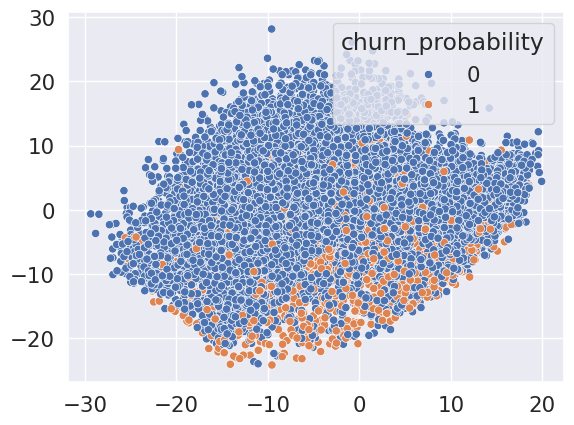

In [122]:
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)
plt.show()

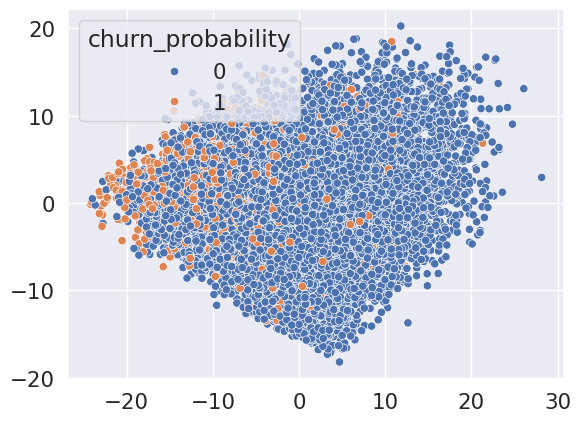

In [123]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)
plt.show()

##### As we can see, there is a clear class imbalance and we have addressed this below using SMOTE

In [124]:
X = high_val_train.copy().drop(['churn_probability'], axis=1)
y = high_val_train.copy()['churn_probability']

In [125]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100)

In [126]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
scaler = StandardScaler()
pca = PCA(n_components=20)
smote = SMOTE(random_state=2)
lr = LogisticRegression(max_iter=1000, tol=0.001, random_state=42)

In [127]:
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
    lr
)

In [128]:
# Define hyperparameters grid for GridSearchCV
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['liblinear', 'saga'],
}

In [129]:
# Instantiate GridSearchCV
lr_grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [130]:
# Fit the model using GridSearchCV
lr_grid_search.fit(X_train, y_train)

# Get the best parameters and estimator
lr_best_params = lr_grid_search.best_params_
lr_best_estimator = lr_grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [131]:
# Predict values on the training set
y_train_pred = lr_grid_search.predict(X_train)

In [132]:
# Predict values on the validation set
y_val_pred = lr_grid_search.predict(X_val)

In [133]:
# Metrics of the training set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[12478  2922]
 [  277  1121]]


Metric   Value
0             Accuracy  0.8096
1          Sensitivity  0.8019
2          Specificity  0.8103
3            Precision  0.2773
4  False Positive Rate  0.1897
5   True Positive Rate  0.8019

In [134]:
# Metrics of the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[3141  722]
 [  77  260]]


Metric   Value
0             Accuracy  0.8098
1          Sensitivity  0.7715
2          Specificity  0.8131
3            Precision  0.2648
4  False Positive Rate  0.1869
5   True Positive Rate  0.7715

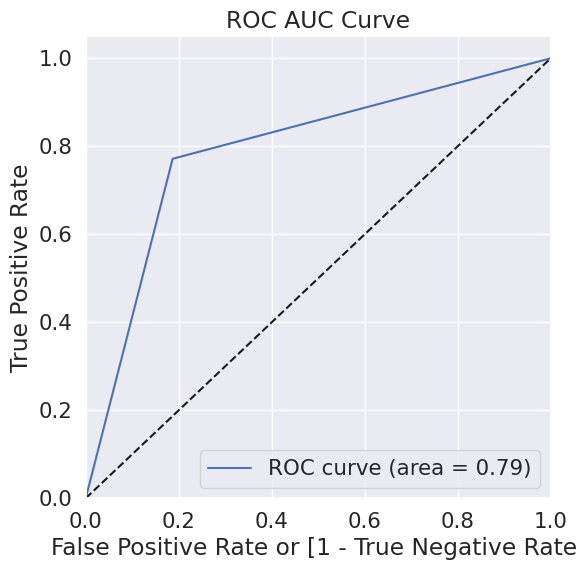

In [135]:
# ROC curve
fpr, tpr, thresholds = draw_roc_curve(y_val, y_val_pred)

### Model 3. Decision Tree with PCA and GridSearchCV

In [136]:
dt = DecisionTreeClassifier(random_state=42)

In [137]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
scaler = StandardScaler()
pca = PCA(n_components=25)
smote = SMOTE(random_state=2)

In [138]:
# Create a pipeline
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
    dt
)

In [139]:
# Create the parameter grid based on the results of random search
params = {
    'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
    'decisiontreeclassifier__min_samples_leaf': [5, 10, 20, 50, 100],
}

In [140]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=pipe,
                           param_grid=params,
                           cv=5, n_jobs=-1, verbose=1, scoring = "accuracy")

In [141]:
# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(fill_value=0,
                                                      strategy='constant')),
                                       ('smote', SMOTE(random_state=2)),
                                       ('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=25)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
                         'decisiontreeclassifier__min_samples_leaf': [5, 10, 20,
                                                                      50,
                                                                      100]},
             scoring='accuracy', verbose=1)

In [142]:
# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Predict on train set using the best model
y_train_pred = grid_search.predict(X_train)

# Predict on validation set using the best model
y_val_pred = grid_search.predict(X_val)

In [143]:
# Metrics on the train set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[14670   730]
 [   72  1326]]


Metric   Value
0             Accuracy  0.9523
1          Sensitivity  0.9485
2          Specificity  0.9526
3            Precision  0.6449
4  False Positive Rate  0.0474
5   True Positive Rate  0.9485

In [144]:
# Metrics on the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[3297  566]
 [ 154  183]]


Metric   Value
0             Accuracy  0.8286
1          Sensitivity  0.5430
2          Specificity  0.8535
3            Precision  0.2443
4  False Positive Rate  0.1465
5   True Positive Rate  0.5430

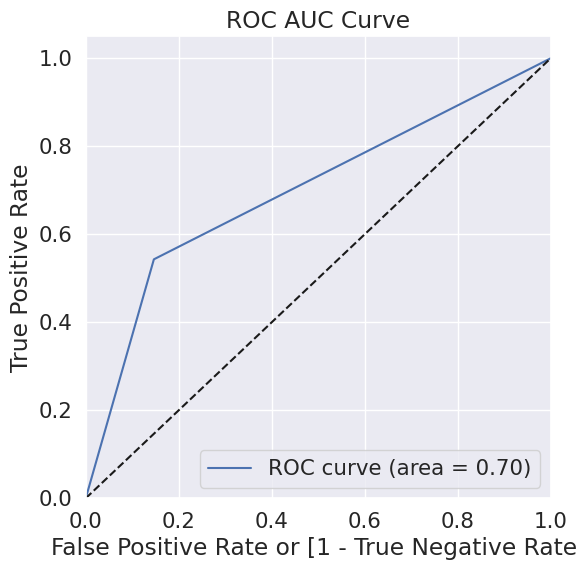

In [145]:
# ROC curve
fpr, tpr, thresholds = draw_roc_curve(y_val, y_val_pred)

### Model 4. Random Forest Classifier with PCA and Hyperparameter Tuning

In [146]:
rf = RandomForestClassifier(random_state=42)

In [147]:
# Create a pipeline
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
    rf
)

In [148]:
# Define the hyperparameters grid for Random Forest
param_grid = {
    'randomforestclassifier__n_estimators': [100],
    'randomforestclassifier__max_depth': [5, 10],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
}

In [149]:
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [150]:
%%time
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 21.5 s, sys: 672 ms, total: 22.2 s
Wall time: 4min 58s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(fill_value=0,
                                                      strategy='constant')),
                                       ('smote', SMOTE(random_state=2)),
                                       ('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=25)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [5, 10],
                         'randomforestclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'randomforestclassifier__n_estimators': [100]},
             scoring='accuracy', verbose=1)

In [151]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on train set using the best model
y_train_pred = best_model.predict(X_train)

# Predict on train set using the validation model
y_test_pred = best_model.predict(X_val)

Best Parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}


In [152]:
# Metrics on the train set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[13954  1446]
 [   81  1317]]


Metric   Value
0             Accuracy  0.9091
1          Sensitivity  0.9421
2          Specificity  0.9061
3            Precision  0.4767
4  False Positive Rate  0.0939
5   True Positive Rate  0.9421

In [153]:
# Metrics on the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[3297  566]
 [ 154  183]]


Metric   Value
0             Accuracy  0.8286
1          Sensitivity  0.5430
2          Specificity  0.8535
3            Precision  0.2443
4  False Positive Rate  0.1465
5   True Positive Rate  0.5430

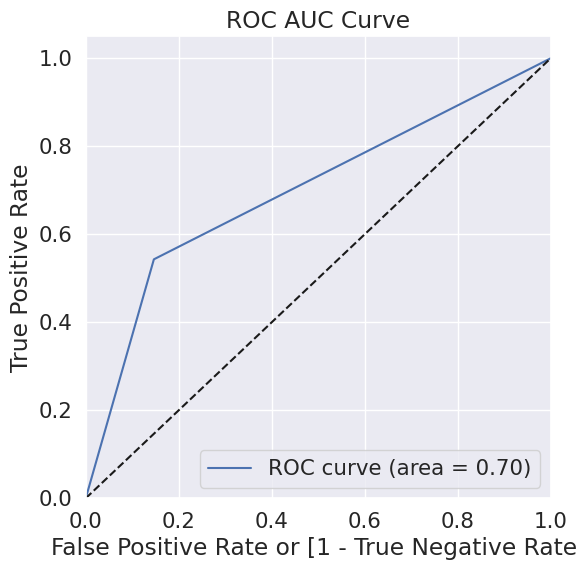

In [154]:
# ROC curve
fpr, tpr, thresholds = draw_roc_curve(y_val, y_val_pred)

### Model 5. AdaBoost Classifier

In [155]:
# Create a pipeline
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
    AdaBoostClassifier(n_estimators=200, random_state=42)
)

In [156]:
# Build the model
adaboost_model = pipe.fit(X_train, y_train)

In [157]:
# Predict on train set using the best model
y_train_pred = adaboost_model.predict(X_train)

# Predict on train set using the validation model
y_test_pred = adaboost_model.predict(X_val)

In [158]:
# Metrics on the train set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[12959  2441]
 [  285  1113]]


Metric   Value
0             Accuracy  0.8377
1          Sensitivity  0.7961
2          Specificity  0.8415
3            Precision  0.3132
4  False Positive Rate  0.1585
5   True Positive Rate  0.7961

In [159]:
# Metrics on the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[3297  566]
 [ 154  183]]


Metric   Value
0             Accuracy  0.8286
1          Sensitivity  0.5430
2          Specificity  0.8535
3            Precision  0.2443
4  False Positive Rate  0.1465
5   True Positive Rate  0.5430

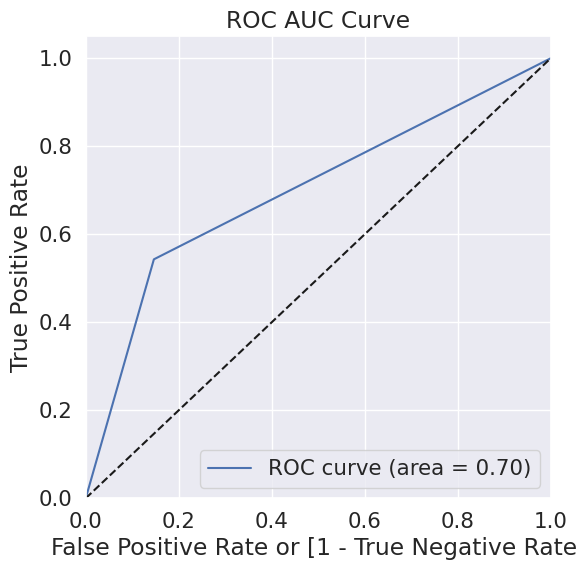

In [160]:
# ROC curve
fpr, tpr, thresholds = draw_roc_curve(y_val, y_val_pred)

### Model 6. XGBoost Classifier

In [161]:
# Create a pipeline
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
    XGBClassifier(random_state=42)
)

In [162]:
# Define hyperparameters for grid search
param_grid = {
    'xgbclassifier__n_estimators': [100, 200, 300],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.3]
}

In [163]:
# Instantiate GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [164]:
%%time
# Train the model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
CPU times: user 16.3 s, sys: 777 ms, total: 17.1 s
Wall time: 5min 18s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(fill_value=0,
                                                      strategy='constant')),
                                       ('smote', SMOTE(random_state=2)),
                                       ('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=25)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      d...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__learning_rate': [0.01, 0.1, 0.3],
                         'xgbclassifier__max_depth': [3, 5, 7],
                         'xgbclassifier__n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [165]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on train set using the best model
y_train_pred = best_model.predict(X_train)

# Predict on train set using the validation model
y_test_pred = best_model.predict(X_val)

Best Parameters: {'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 7, 'xgbclassifier__n_estimators': 300}


In [166]:
# Metrics on the train set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[15400     0]
 [    0  1398]]


Metric  Value
0             Accuracy    1.0
1          Sensitivity    1.0
2          Specificity    1.0
3            Precision    1.0
4  False Positive Rate    0.0
5   True Positive Rate    1.0

In [167]:
# Metrics on the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[3297  566]
 [ 154  183]]


Metric   Value
0             Accuracy  0.8286
1          Sensitivity  0.5430
2          Specificity  0.8535
3            Precision  0.2443
4  False Positive Rate  0.1465
5   True Positive Rate  0.5430

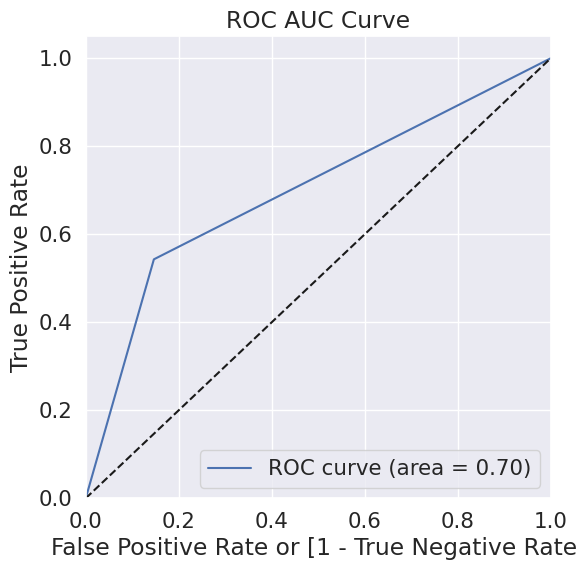

In [168]:
# ROC curve
fpr, tpr, thresholds = draw_roc_curve(y_val, y_val_pred)

### 9. Create `submission.csv` file for final submission on Kaggle

For our Kaggle submission, we are going with logistic regression with Recursive Feature Elimination (RFE) due to the platform's evaluation metric being accuracy. This model consistently achieves approximately 86% accuracy on both the training and test sets. Notably, it also demonstrates a commendable accuracy of 93.8% on previously unseen data.

In [169]:
submission_data = final_unseen_df[selected_features]
submission_data.shape

(30000, 20)

In [170]:
final_unseen_df['churn_probability'] = logreg.predict(submission_data)
output = final_unseen_df[['churn_probability']]
output.head()

churn_probability
id                      
69999                  0
70000                  0
70001                  1
70002                  0
70003                  0

In [171]:
output.to_csv('submission.csv',index=True)

### 10. Business Recommendations

Based on the analysis of our logistic regression model with RFE, here are some business ideas to improve churn rate:

1. Provide personalized roaming packages to frequent roamers.
2. Offer competitive rates and bonuses for local calls.
4. Offer discounts for high-value recharges to retain customers.
5. Enhance engagement through loyalty programs and personalized offers.
6. Target customers with low recharge activity with special offers.
7. Encourage non-data users to try data services with bundle offers.
8. Promote data packs with targeted marketing campaigns.

Implementing these strategies can effectively reduce churn and improve customer retention in your telecom business.

### 11. Summary

After experimenting with various models, including Logistic Regression with Recursive Feature Elimination (RFE), Logistic Regression with hyperparameter tuning, and PCA, as well as Decision Tree, Random Forest, Adaboost, and XGBoost classifiers with hyperparameter tuning and PCA, it's evident that only Logistic Regression with PCA consistently demonstrates the highest sensitivity in both the train and validation sets. Consequently, this model should be considered as the final choice. Other models, although showing promising accuracy in the training phase, perform poorly on the test set, suggesting overfitting.

In the context of telecom churn, where minimizing churn rate is crucial, sensitivity emerges as the most pertinent metric. Hence, based on this criterion, the Logistic Regression model with PCA stands out as the most suitable choice among all alternatives.